## Dataset

Let's consider the MNIST and SVHN datasets to implement our joint VAE. These datasets can be directly downloaded from the Pytorch vision package.

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

# Load SVHN dataset
svhn_data = datasets.SVHN(root='./data/SVHN', split='train', download=True, transform=transforms.ToTensor())
svhn_loader = DataLoader(svhn_data, batch_size=64, shuffle=True)


Using downloaded and verified file: ./data/SVHN\train_32x32.mat


Showing 64 samples out of 60000 for: MNIST Samples


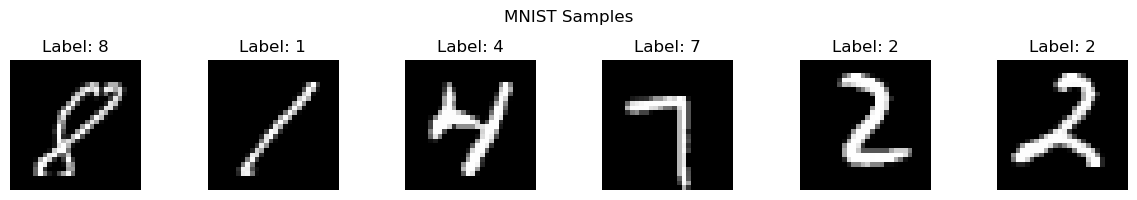

Showing 64 samples out of 73257 for: SVHN Samples


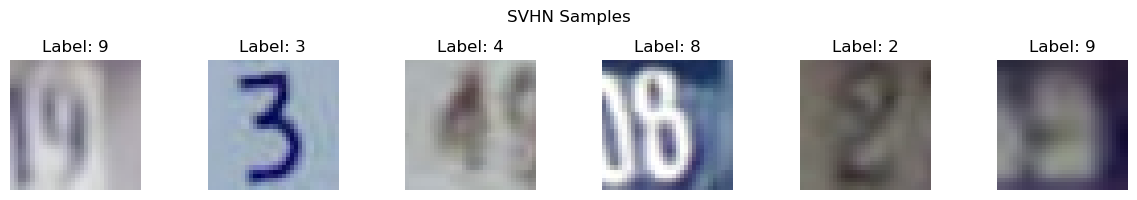

In [2]:
# Visualize some samples from both datasets
import matplotlib.pyplot as plt

def show_samples(data_loader, title):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i in range(6):
        if images.shape[1] == 1:  # Grayscale image (MNIST)
            axes[i].imshow(images[i].squeeze(), cmap='gray')
        else:  # Color image (SVHN)
            axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    num_samples = images.shape[0]
    print(f"Showing {num_samples} samples out of {len(data_loader.dataset)} for: {title}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(mnist_loader, 'MNIST Samples')
show_samples(svhn_loader, 'SVHN Samples')

Now that we have defined our datasets, we can proceed to implement the joint VAE architecture and training procedure. First, let us ensure our **joint** database is correctly set up. That is, for each MNIST image, we need to have a corresponding SVHN image with the same label (digit). This can be achieved by filtering and pairing the datasets based on their labels.

In [8]:
# Filter and pair datasets based on labels
import numpy as np

# Get all labels
mnist_labels = mnist_data.targets.numpy()
svhn_labels = svhn_data.labels

# Create dictionaries mapping labels to indices
mnist_label_to_indices = {label: [] for label in range(10)}
svhn_label_to_indices = {label: [] for label in range(10)}

# Populate the dictionaries
for i, label in enumerate(mnist_labels):
    mnist_label_to_indices[label].append(i)

for i, label in enumerate(svhn_labels):
    svhn_label_to_indices[label].append(i)

paired_mnist_indices = []
paired_svhn_indices = []

# Pair samples with the same label
for label in range(10):
    mnist_indices = mnist_label_to_indices[label]
    svhn_indices = svhn_label_to_indices[label]

    # Pair up to min count
    min_count = min(len(mnist_indices), len(svhn_indices))
    paired_mnist_indices.extend(mnist_indices[:min_count])
    paired_svhn_indices.extend(svhn_indices[:min_count])

print(f"MNIST samples: {len(mnist_labels)}")
print(f"SVHN samples: {len(svhn_labels)}")
print(f"Paired samples: {len(paired_mnist_indices)}")

# Create paired loaders using indices
class PairedDataset:
    def __init__(self, dataset1, dataset2, indices1, indices2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.indices1 = indices1
        self.indices2 = indices2
    
    def __len__(self):
        return len(self.indices1)
    
    def __getitem__(self, idx):
        img1, label1 = self.dataset1[self.indices1[idx]]
        img2, label2 = self.dataset2[self.indices2[idx]]
        return img1, img2, label1, label2

paired_dataset = PairedDataset(mnist_data, svhn_data, paired_mnist_indices, paired_svhn_indices)
paired_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True)

# Updated visualization
def show_paired_samples(loader):
    images1, images2, labels1, labels2 = next(iter(loader))
    
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        axes[0, i].imshow(images1[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'MNIST: {labels1[i]}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(images2[i].permute(1, 2, 0))
        axes[1, i].set_title(f'SVHN: {labels2[i]}')
        axes[1, i].axis('off')
    
    plt.suptitle('Paired MNIST and SVHN Samples')
    plt.tight_layout()
    plt.show()

MNIST samples: 60000
SVHN samples: 73257
Paired samples: 56068


We have created a `PairedDataset` class that takes two datasets and pairs samples with matching labels. Note that only 56068 pairs were formed since both datasets do not have the same number of samples for each digit. The number of paired samples has an upper bound defined by:

$$\text{Number of pairs} \leq \min(\text{\# MNIST samples}, \text{\# SVHN samples})$$

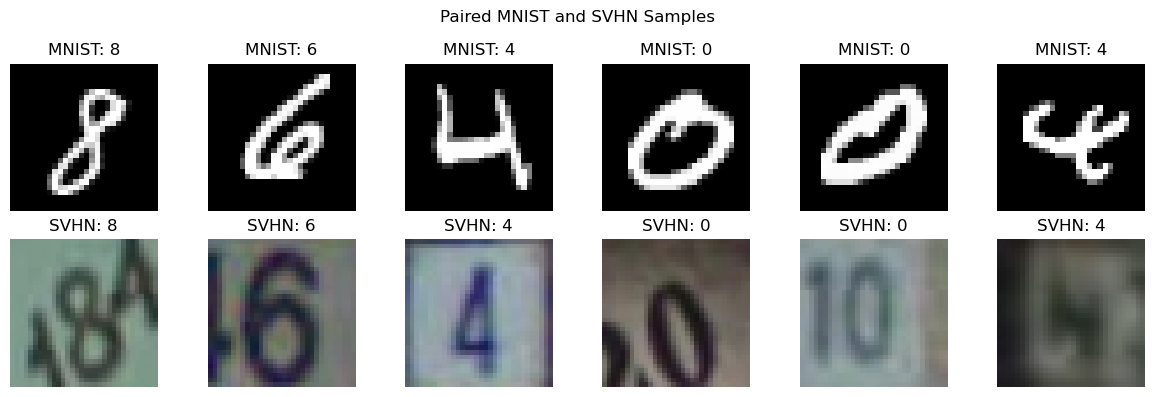

In [10]:
show_paired_samples(paired_loader)

## Multi-View VAE Implementation

Now that we have our paired dataset, we can proceed to implement the multi-view VAE architecture. The joint VAE will consist of separate encoders and decoders for each view (MNIST and SVHN) but will share a common latent space.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Helper functions for reparameterization and Product of Experts
def reparameterize(mu, logvar):
    """
    Reparameterization trick: z = mu + std * epsilon
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def product_of_experts(mu1, logvar1, mu2, logvar2):
    """
    Combines two Gaussian experts using Product of Experts.
    Returns the parameters (mu, logvar) of the joint distribution.
    Assumes diagonal covariance matrices.
    """
    var1 = torch.exp(logvar1)
    var2 = torch.exp(logvar2)

    # Precision is inverse variance
    precision1 = 1.0 / var1
    precision2 = 1.0 / var2

    # Joint precision is sum of precisions
    joint_precision = precision1 + precision2

    # Joint variance is inverse of joint precision
    joint_var = 1.0 / joint_precision

    # Joint mean is precision-weighted sum of means
    joint_mu = (mu1 * precision1 + mu2 * precision2) * joint_var

    # Joint log variance
    joint_logvar = torch.log(joint_var)

    return joint_mu, joint_logvar


# Encoder architecture(s) using simple CNNs
class MNISTEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class SVHNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(SVHNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # -> 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # -> 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # -> 4x4
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Decoder architecture(s) using simple CNNs
class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # -> 14x14
        self.deconv2 = nn.ConvTranspose2d(
            32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # -> 28x28

    # Forward pass
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 64, 7, 7)  # Reshape
        z = F.relu(self.deconv1(z))
        # Use sigmoid for output layer for BCE loss (pixels in [0, 1])
        x_recon = torch.sigmoid(self.deconv2(z))
        return x_recon


class SVHNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(SVHNDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # -> 8x8
        self.deconv2 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # -> 16x16
        self.deconv3 = nn.ConvTranspose2d(
            32, 3, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # -> 32x32

    # Forward pass
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 128, 4, 4)  # Reshape
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        # Use sigmoid for output layer (pixels in [0, 1])
        x_recon = torch.sigmoid(self.deconv3(z))
        return x_recon

Now that we have defined our helper functions and encoder/decoder architectures, we can proceed to implement the training loop for our multi-view VAE. The training process involves optimizing the combined loss function that includes reconstruction losses for both views and the KL divergence term.

In [12]:
# Multi-View VAE Model
class MultiViewVAE(nn.Module):
    def __init__(self, latent_dim):
        super(MultiViewVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_mnist = MNISTEncoder(latent_dim)
        self.encoder_svhn = SVHNEncoder(latent_dim)
        self.decoder_mnist = MNISTDecoder(latent_dim)
        self.decoder_svhn = SVHNDecoder(latent_dim)

    # Forward pass
    def forward(self, x_mnist, x_svhn):
        # Encode each modality
        mu_mnist, logvar_mnist = self.encoder_mnist(x_mnist)
        mu_svhn, logvar_svhn = self.encoder_svhn(x_svhn)

        # Combine using Product of Experts to get joint posterior parameters
        mu_joint, logvar_joint = product_of_experts(
            mu_mnist, logvar_mnist, mu_svhn, logvar_svhn
        )

        # Sample from the joint posterior using reparameterization trick
        z_joint = reparameterize(mu_joint, logvar_joint)

        # Decode using the joint latent variable
        x_recon_mnist = self.decoder_mnist(z_joint)
        x_recon_svhn = self.decoder_svhn(z_joint)

        return (
            x_recon_mnist,
            x_recon_svhn,
            mu_joint,
            logvar_joint,
            mu_mnist,
            logvar_mnist,  # Also return individual params if needed for analysis/loss variations
            mu_svhn,
            logvar_svhn,
        )

    def generate(self, z):
        """Generate samples from latent variable z"""
        self.eval()  # Put model in evaluation mode
        with torch.no_grad():
            x_gen_mnist = self.decoder_mnist(z)
            x_gen_svhn = self.decoder_svhn(z)
        return x_gen_mnist, x_gen_svhn

    def reconstruct_cross(self, x_mnist=None, x_svhn=None):
        """Reconstruct one modality given the other"""
        self.eval()
        with torch.no_grad():
            if x_mnist is not None and x_svhn is None:
                # Use MNIST encoder to get latent z, then decode with SVHN decoder
                mu, logvar = self.encoder_mnist(x_mnist)
                z = reparameterize(mu, logvar)  # Could also just use mu
                x_cross_svhn = self.decoder_svhn(z)
                x_recon_mnist = self.decoder_mnist(z)  # Also reconstruct original
                return x_recon_mnist, x_cross_svhn
            elif x_svhn is not None and x_mnist is None:
                # Use SVHN encoder to get latent z, then decode with MNIST decoder
                mu, logvar = self.encoder_svhn(x_svhn)
                z = reparameterize(mu, logvar)  # Could also just use mu
                x_cross_mnist = self.decoder_mnist(z)
                x_recon_svhn = self.decoder_svhn(z)  # Also reconstruct original
                return x_cross_mnist, x_recon_svhn
            else:
                raise ValueError(
                    "Provide exactly one input modality (x_mnist or x_svhn)"
                )

We now define the loss function for the multi-view VAE. The loss consists of three components: the reconstruction loss for the MNIST view, the reconstruction loss for the SVHN view, and the KL divergence loss that regularizes the latent space.

In [13]:
def vae_loss(
    x_recon_mnist, x_mnist, x_recon_svhn, x_svhn, mu_joint, logvar_joint, beta=1.0
):
    """
    Computes the VAE loss (Evidence Lower Bound - ELBO).
    Uses Binary Cross-Entropy (BCE) for reconstruction.
    Assumes inputs x_mnist, x_svhn are scaled to [0, 1].
    """
    # Reconstruction Loss (summed over pixels and batch)
    # Using BCE loss assuming inputs are normalized [0,1] and decoder output is sigmoid
    recon_loss_mnist = F.binary_cross_entropy(
        x_recon_mnist.view(-1, 28 * 28), x_mnist.view(-1, 28 * 28), reduction="sum"
    )
    recon_loss_svhn = F.binary_cross_entropy(
        x_recon_svhn.view(-1, 3 * 32 * 32),
        x_svhn.view(-1, 3 * 32 * 32),
        reduction="sum",
    )

    # KL Divergence (between joint posterior q(z|x1,x2) and prior p(z)=N(0,I))
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_div = -0.5 * torch.sum(1 + logvar_joint - mu_joint.pow(2) - logvar_joint.exp())

    # Total Loss (negative ELBO) - averaged over batch size
    batch_size = x_mnist.size(0)
    total_loss = (recon_loss_mnist + recon_loss_svhn + beta * kl_div) / batch_size

    return (
        total_loss,
        recon_loss_mnist / batch_size,
        recon_loss_svhn / batch_size,
        kl_div / batch_size,
    )

Everything is now set up to train our multi-view VAE on the paired MNIST and SVHN datasets. We will train the model for a specified number of epochs, monitoring the loss to ensure that the model is learning effectively.

Train Epoch: 0 [0/56068 (0%)]	Loss: 2595.520996 ReconM: 471.4587 ReconS: 2122.1311 KLD: 1.9312
Train Epoch: 0 [6400/56068 (11%)]	Loss: 2212.604248 ReconM: 199.9477 ReconS: 2003.2095 KLD: 9.4470
Train Epoch: 0 [12800/56068 (23%)]	Loss: 2205.250977 ReconM: 192.3721 ReconS: 2003.9862 KLD: 8.8925
Train Epoch: 0 [19200/56068 (34%)]	Loss: 2158.693359 ReconM: 176.2326 ReconS: 1970.1387 KLD: 12.3221
Train Epoch: 0 [25600/56068 (46%)]	Loss: 2111.870605 ReconM: 145.5376 ReconS: 1948.1372 KLD: 18.1958
Train Epoch: 0 [32000/56068 (57%)]	Loss: 2092.637939 ReconM: 126.7935 ReconS: 1945.0388 KLD: 20.8056
Train Epoch: 0 [38400/56068 (68%)]	Loss: 2093.048096 ReconM: 126.5393 ReconS: 1944.7886 KLD: 21.7203
Train Epoch: 0 [44800/56068 (80%)]	Loss: 2116.052734 ReconM: 110.4814 ReconS: 1983.0234 KLD: 22.5479
Train Epoch: 0 [51200/56068 (91%)]	Loss: 2048.619385 ReconM: 109.9220 ReconS: 1914.9539 KLD: 23.7434
====> Epoch: 0 Average loss: 2138.3979


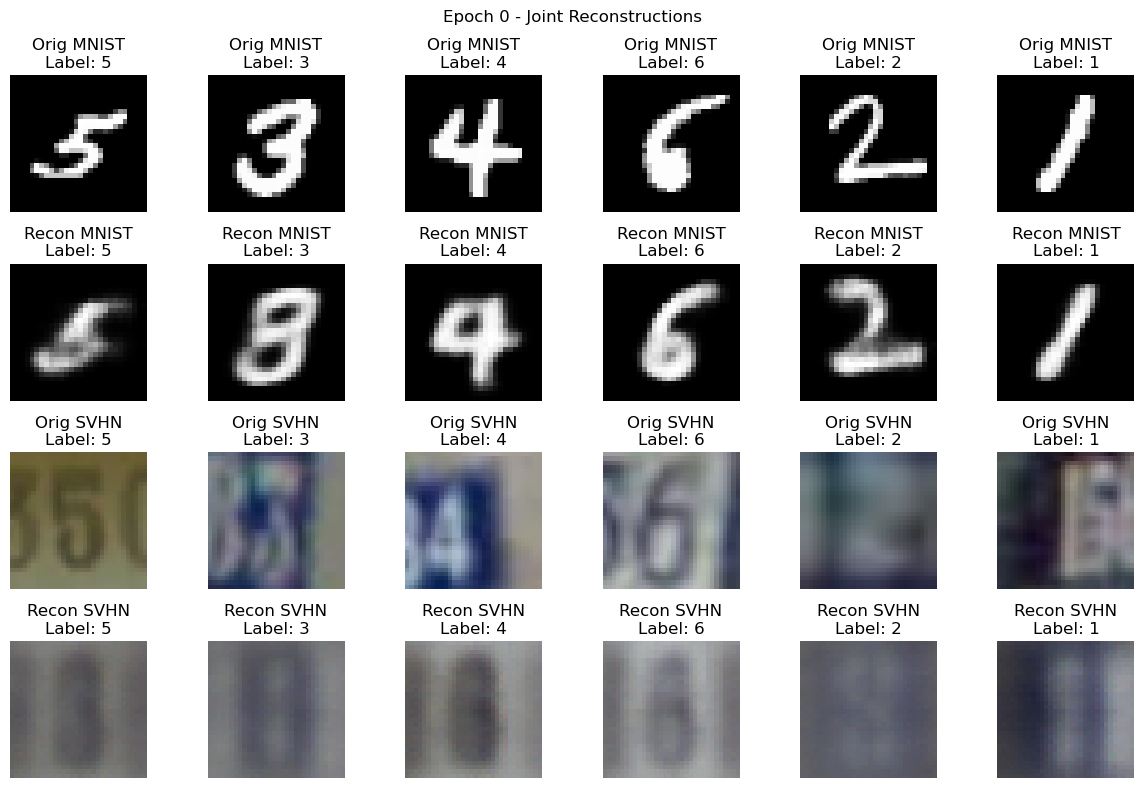

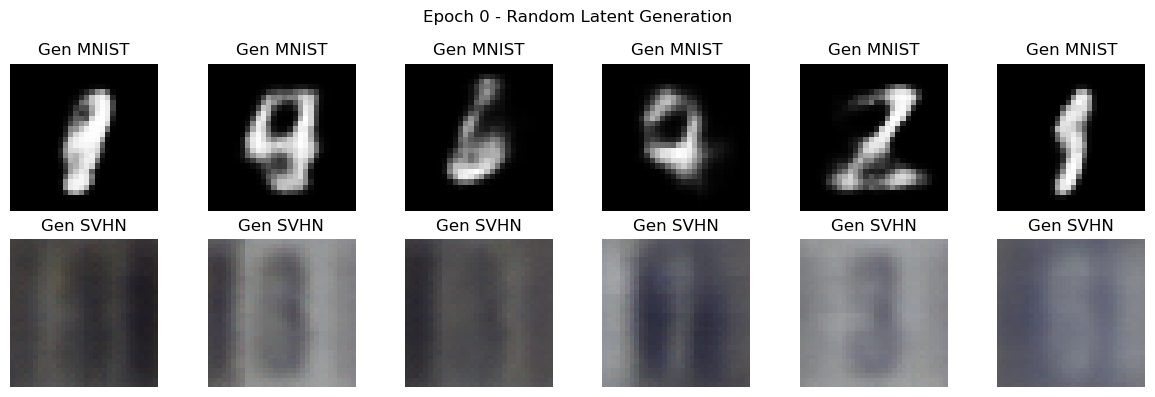

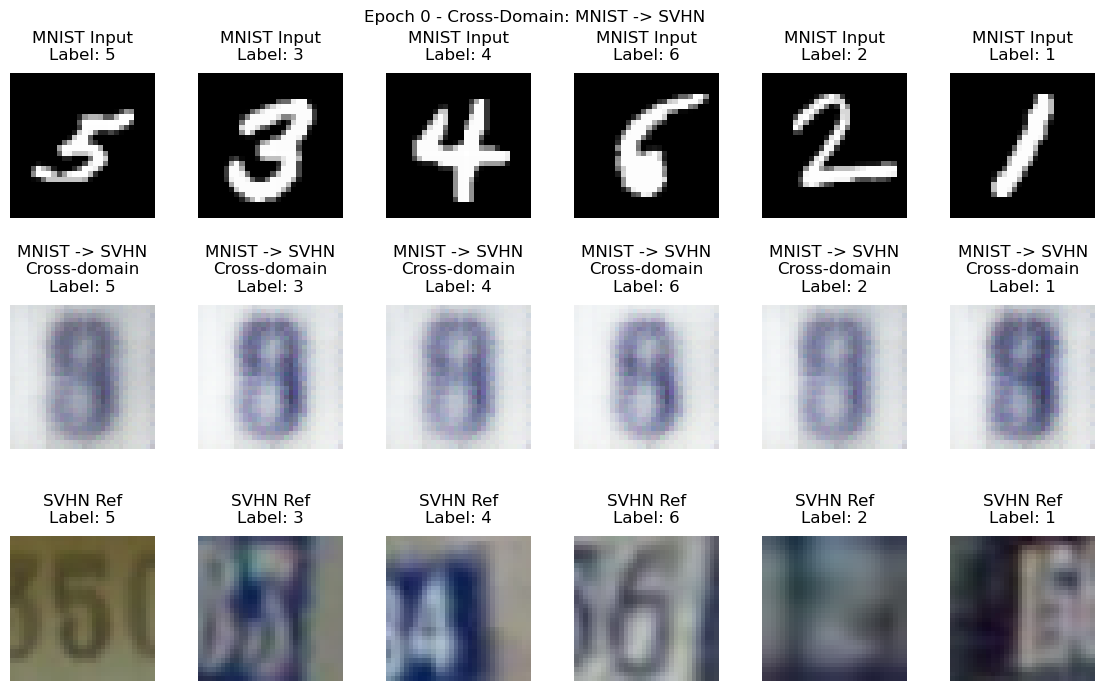

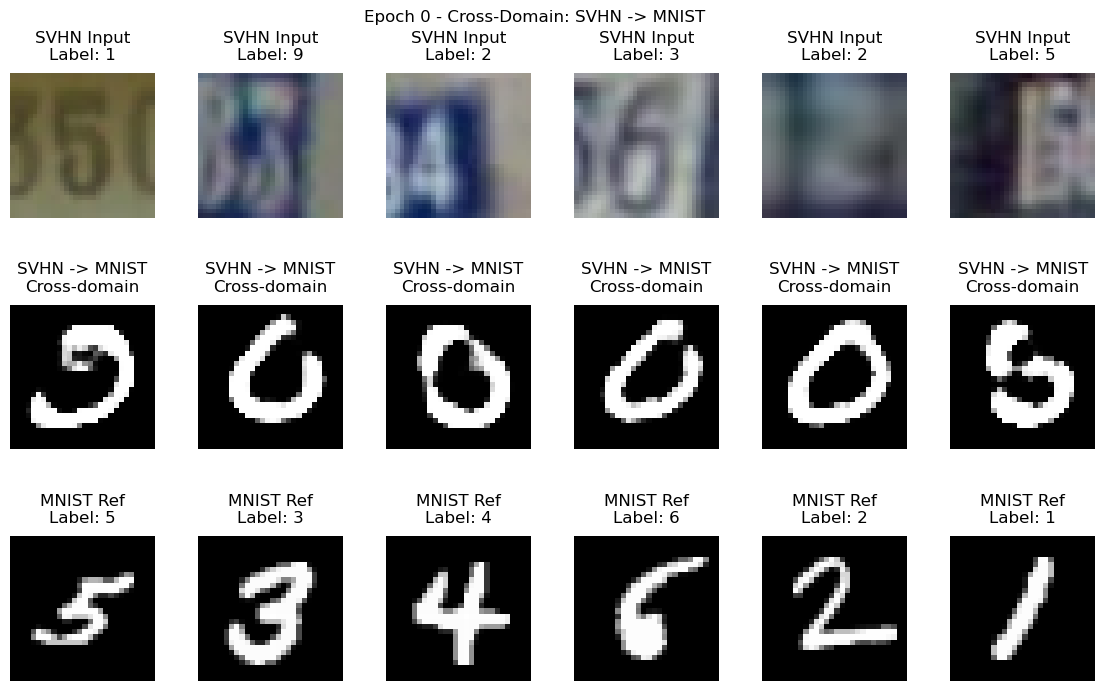

Train Epoch: 1 [0/56068 (0%)]	Loss: 2046.342285 ReconM: 114.6870 ReconS: 1907.4525 KLD: 24.2029
Train Epoch: 1 [6400/56068 (11%)]	Loss: 2083.087891 ReconM: 98.9552 ReconS: 1960.5444 KLD: 23.5882
Train Epoch: 1 [12800/56068 (23%)]	Loss: 2042.275879 ReconM: 109.6901 ReconS: 1907.8472 KLD: 24.7385
Train Epoch: 1 [19200/56068 (34%)]	Loss: 2069.498779 ReconM: 97.0635 ReconS: 1947.7917 KLD: 24.6435
Train Epoch: 1 [25600/56068 (46%)]	Loss: 2087.754883 ReconM: 105.1007 ReconS: 1957.2074 KLD: 25.4467
Train Epoch: 1 [32000/56068 (57%)]	Loss: 2095.869385 ReconM: 105.8838 ReconS: 1963.3059 KLD: 26.6798
Train Epoch: 1 [38400/56068 (68%)]	Loss: 2072.411133 ReconM: 99.1961 ReconS: 1946.8649 KLD: 26.3502
Train Epoch: 1 [44800/56068 (80%)]	Loss: 2032.428101 ReconM: 93.3537 ReconS: 1912.8552 KLD: 26.2192
Train Epoch: 1 [51200/56068 (91%)]	Loss: 2089.315918 ReconM: 98.3631 ReconS: 1964.3799 KLD: 26.5729
====> Epoch: 1 Average loss: 2052.1471
Train Epoch: 2 [0/56068 (0%)]	Loss: 2068.681152 ReconM: 97.1375

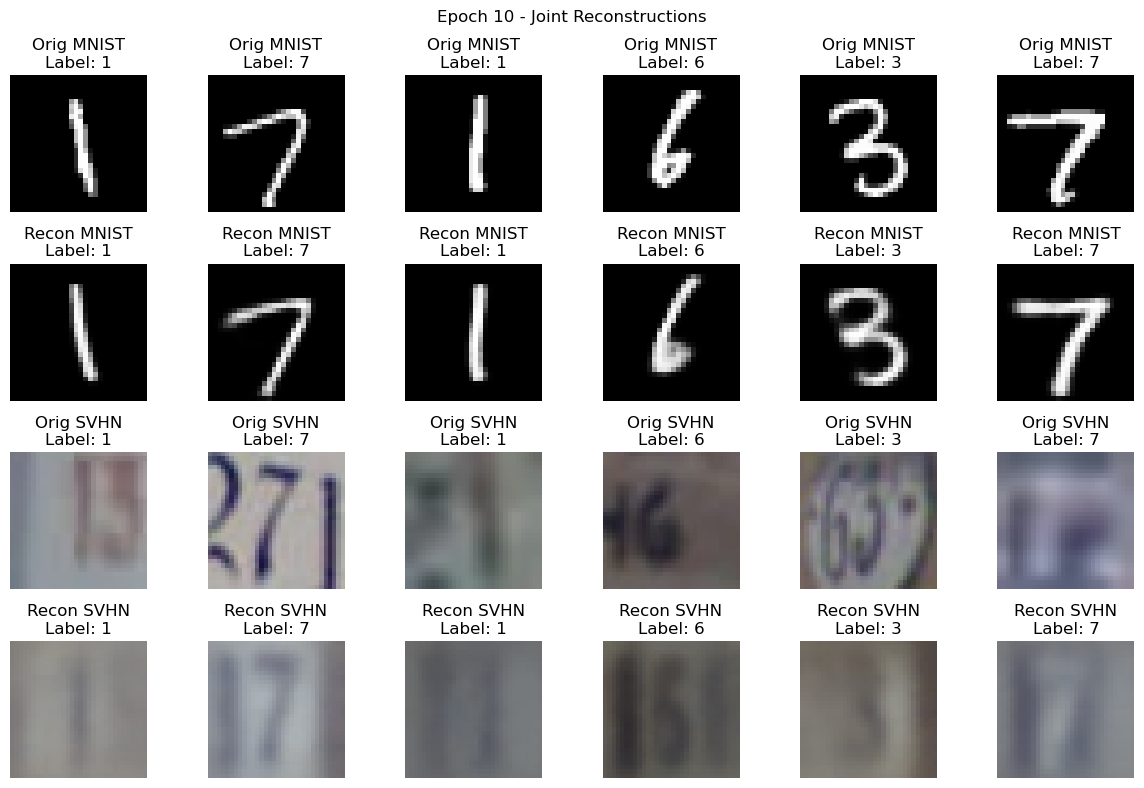

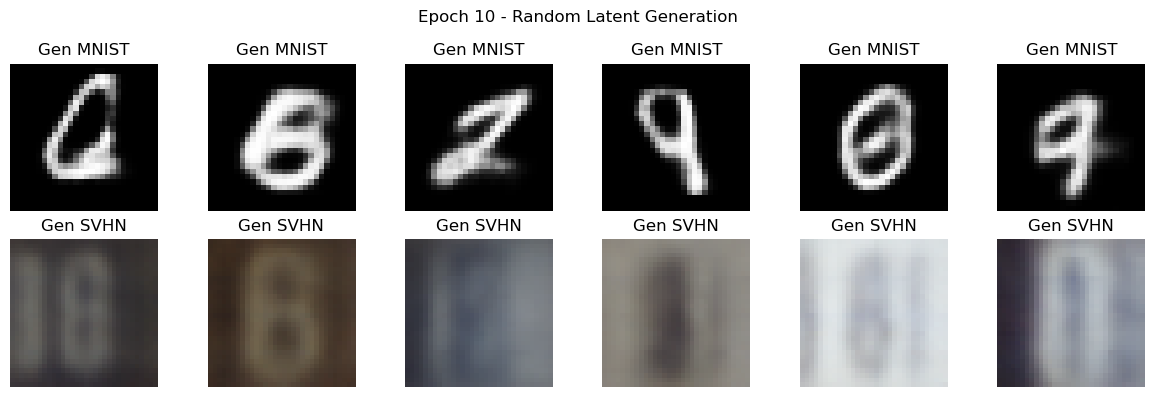

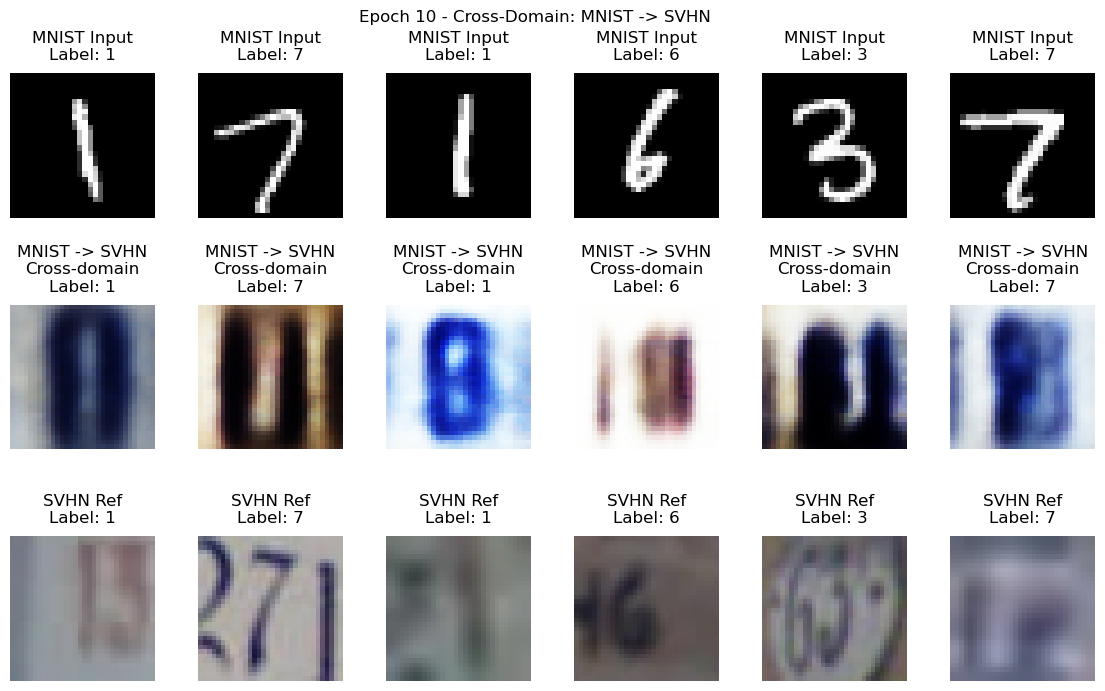

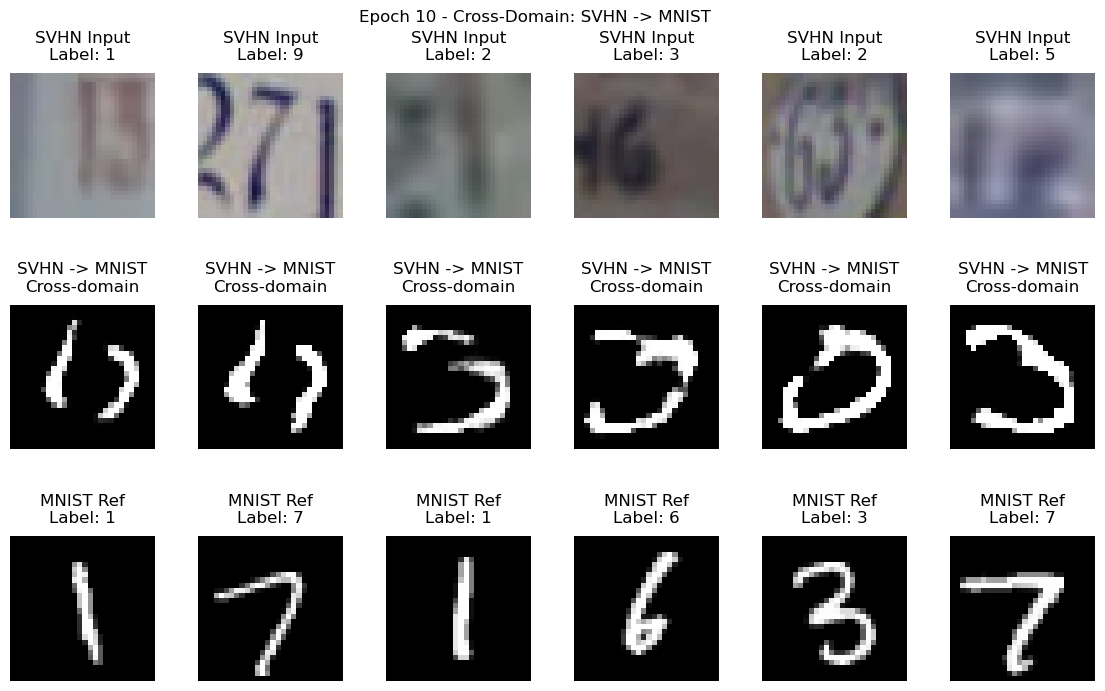

Train Epoch: 11 [0/56068 (0%)]	Loss: 2056.468018 ReconM: 82.0874 ReconS: 1940.2056 KLD: 34.1750
Train Epoch: 11 [6400/56068 (11%)]	Loss: 2028.863037 ReconM: 77.3427 ReconS: 1917.7944 KLD: 33.7259
Train Epoch: 11 [12800/56068 (23%)]	Loss: 1999.794434 ReconM: 77.2983 ReconS: 1889.0171 KLD: 33.4791
Train Epoch: 11 [19200/56068 (34%)]	Loss: 2044.991699 ReconM: 77.0915 ReconS: 1935.4351 KLD: 32.4652
Train Epoch: 11 [25600/56068 (46%)]	Loss: 2025.717041 ReconM: 77.6610 ReconS: 1914.7537 KLD: 33.3024
Train Epoch: 11 [32000/56068 (57%)]	Loss: 2006.064819 ReconM: 76.3560 ReconS: 1896.4550 KLD: 33.2537
Train Epoch: 11 [38400/56068 (68%)]	Loss: 2021.002319 ReconM: 79.0699 ReconS: 1908.1185 KLD: 33.8138
Train Epoch: 11 [44800/56068 (80%)]	Loss: 2061.848877 ReconM: 87.2599 ReconS: 1941.7048 KLD: 32.8842
Train Epoch: 11 [51200/56068 (91%)]	Loss: 1991.896729 ReconM: 79.1277 ReconS: 1879.9612 KLD: 32.8079
====> Epoch: 11 Average loss: 2015.7146
Train Epoch: 12 [0/56068 (0%)]	Loss: 1988.742432 ReconM: 

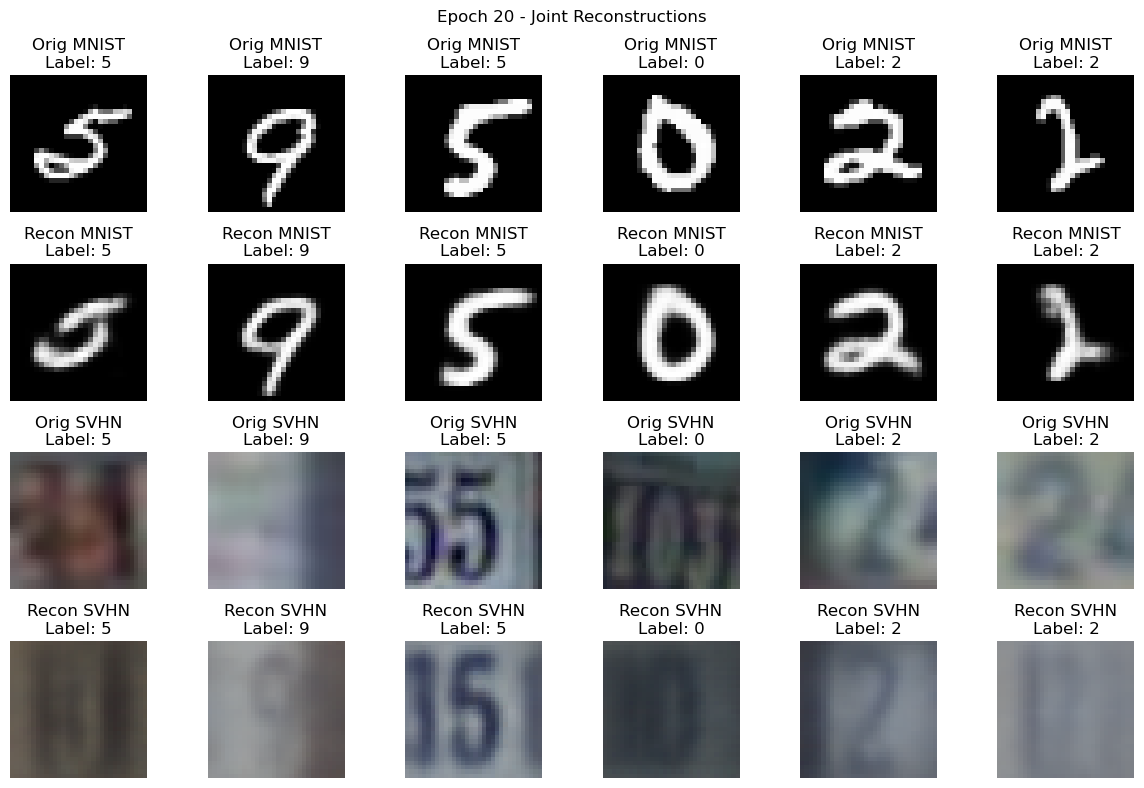

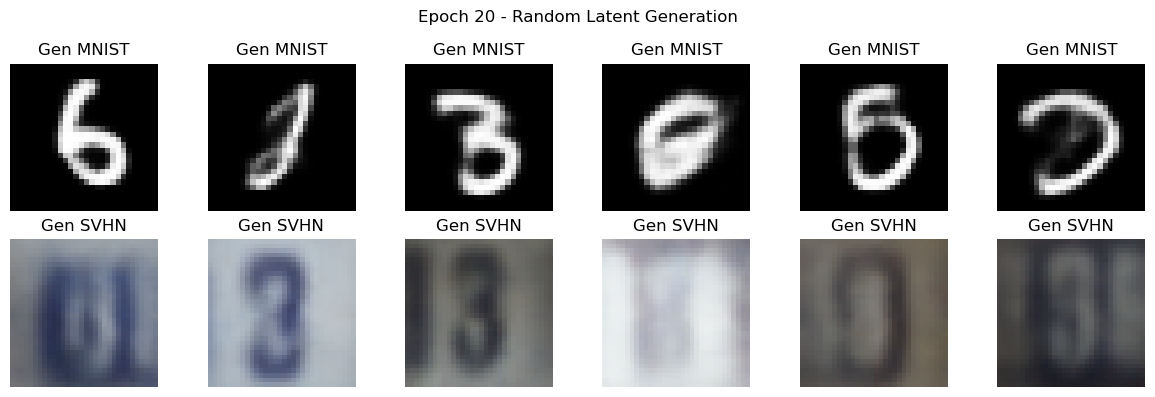

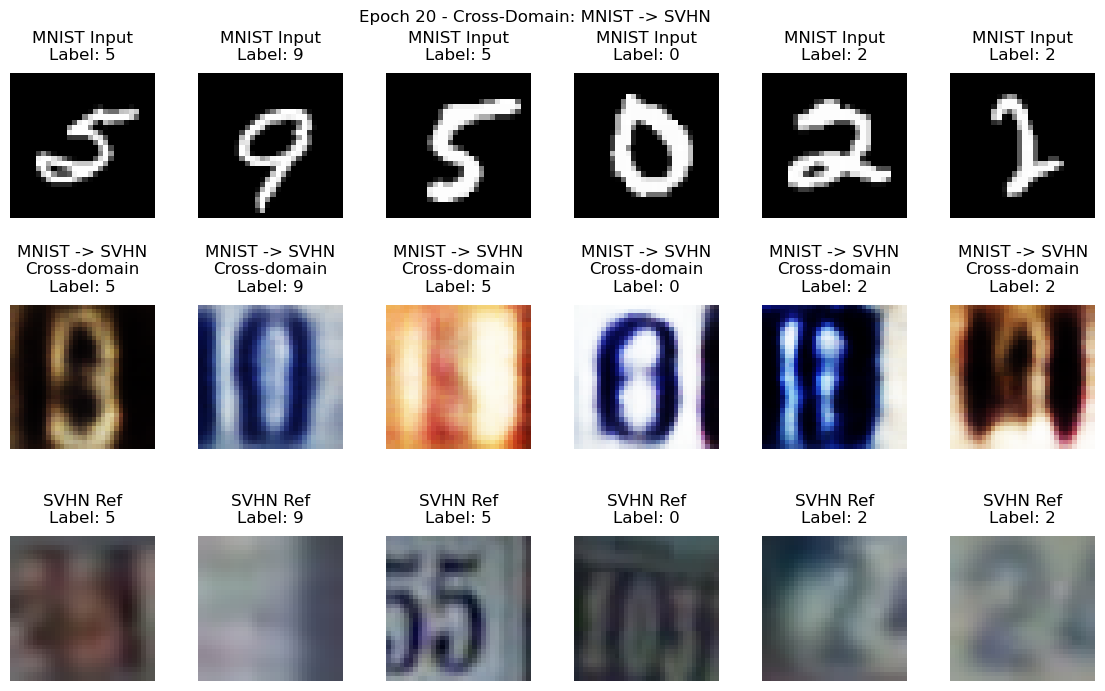

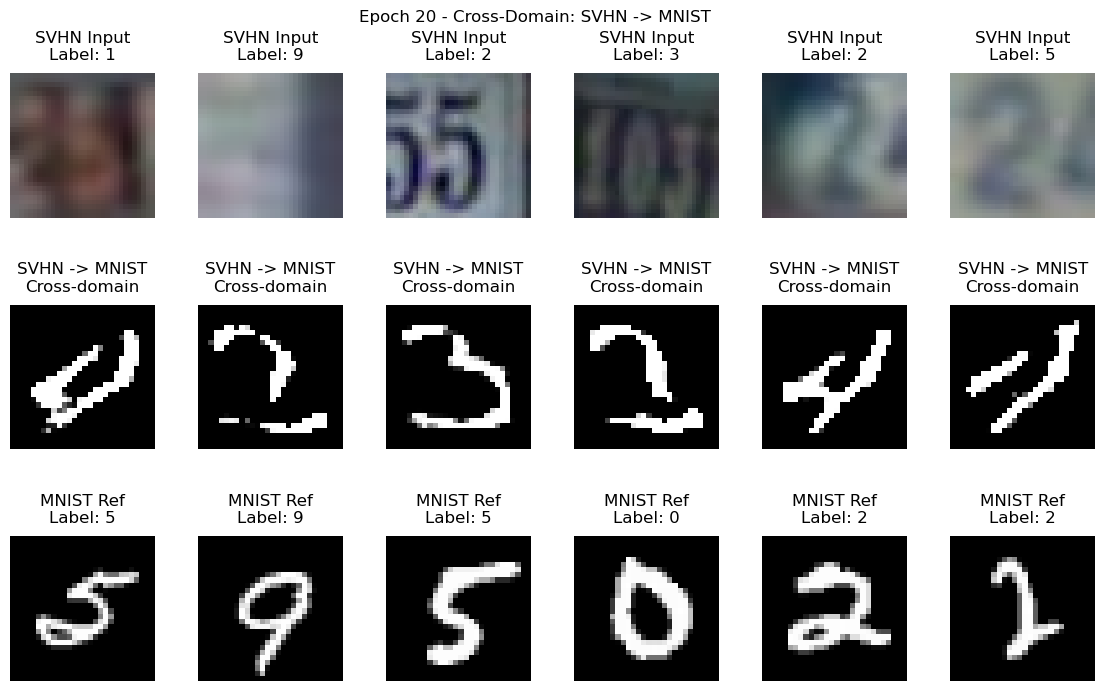

Train Epoch: 21 [0/56068 (0%)]	Loss: 1986.925293 ReconM: 74.5721 ReconS: 1878.6270 KLD: 33.7261
Train Epoch: 21 [6400/56068 (11%)]	Loss: 1987.739136 ReconM: 84.4740 ReconS: 1869.1179 KLD: 34.1472
Train Epoch: 21 [12800/56068 (23%)]	Loss: 1991.698730 ReconM: 77.9056 ReconS: 1880.2174 KLD: 33.5757
Train Epoch: 21 [19200/56068 (34%)]	Loss: 2008.331055 ReconM: 78.7644 ReconS: 1894.8889 KLD: 34.6777
Train Epoch: 21 [25600/56068 (46%)]	Loss: 2015.741333 ReconM: 79.8918 ReconS: 1900.9458 KLD: 34.9038
Train Epoch: 21 [32000/56068 (57%)]	Loss: 1974.928345 ReconM: 81.7977 ReconS: 1857.6345 KLD: 35.4961
Train Epoch: 21 [38400/56068 (68%)]	Loss: 1985.224487 ReconM: 78.1758 ReconS: 1872.4957 KLD: 34.5529
Train Epoch: 21 [44800/56068 (80%)]	Loss: 2020.728271 ReconM: 75.6220 ReconS: 1911.2007 KLD: 33.9056
Train Epoch: 21 [51200/56068 (91%)]	Loss: 2020.472778 ReconM: 77.7202 ReconS: 1908.8198 KLD: 33.9327
====> Epoch: 21 Average loss: 2010.2824
Train Epoch: 22 [0/56068 (0%)]	Loss: 1979.088989 ReconM: 

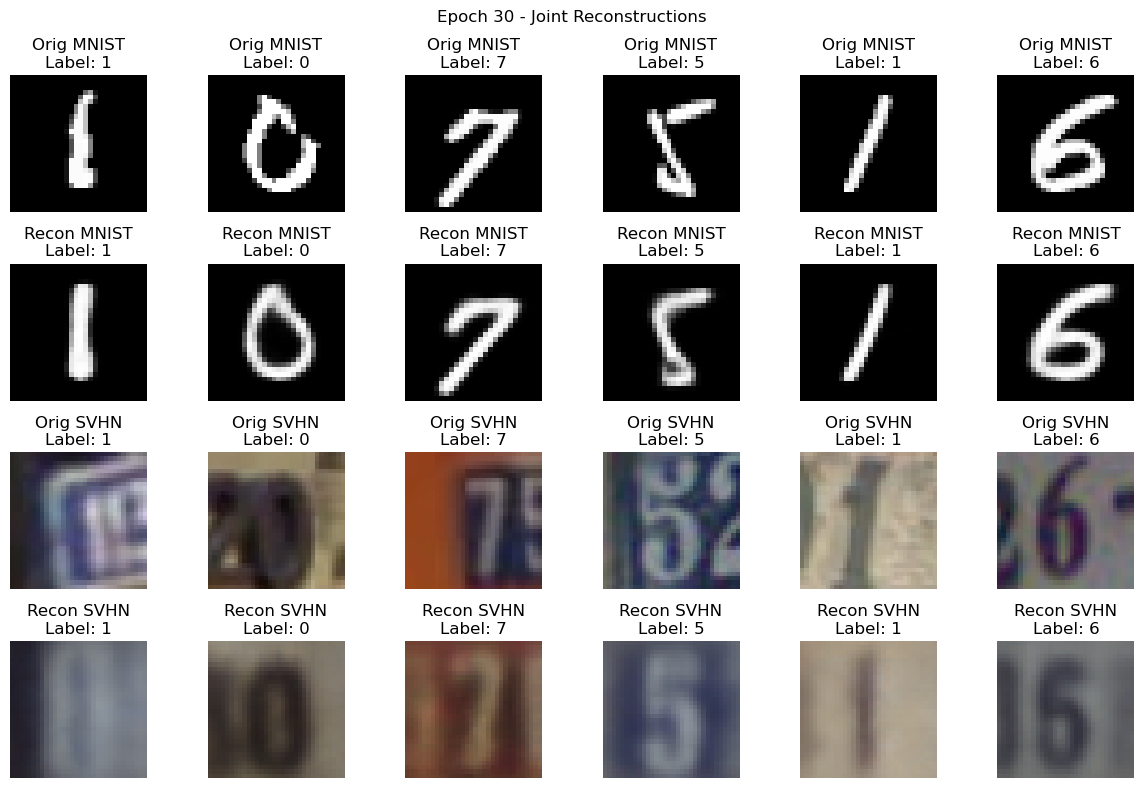

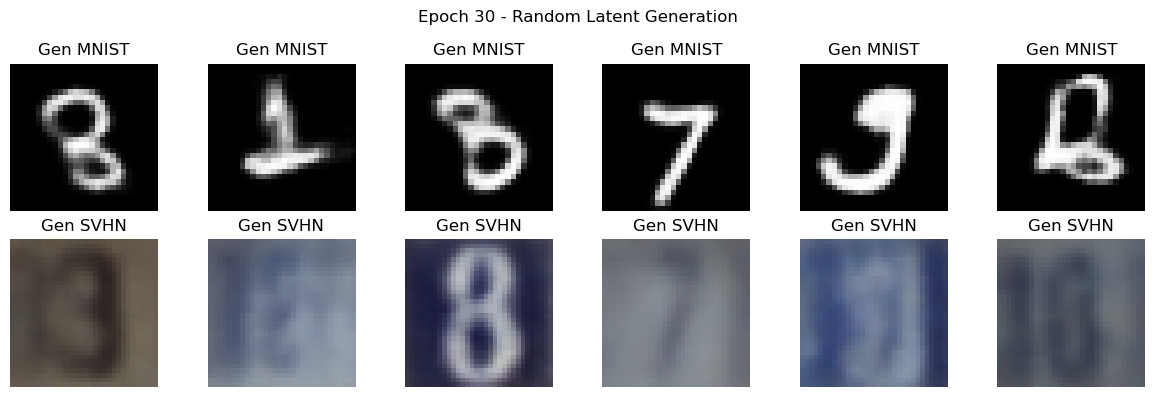

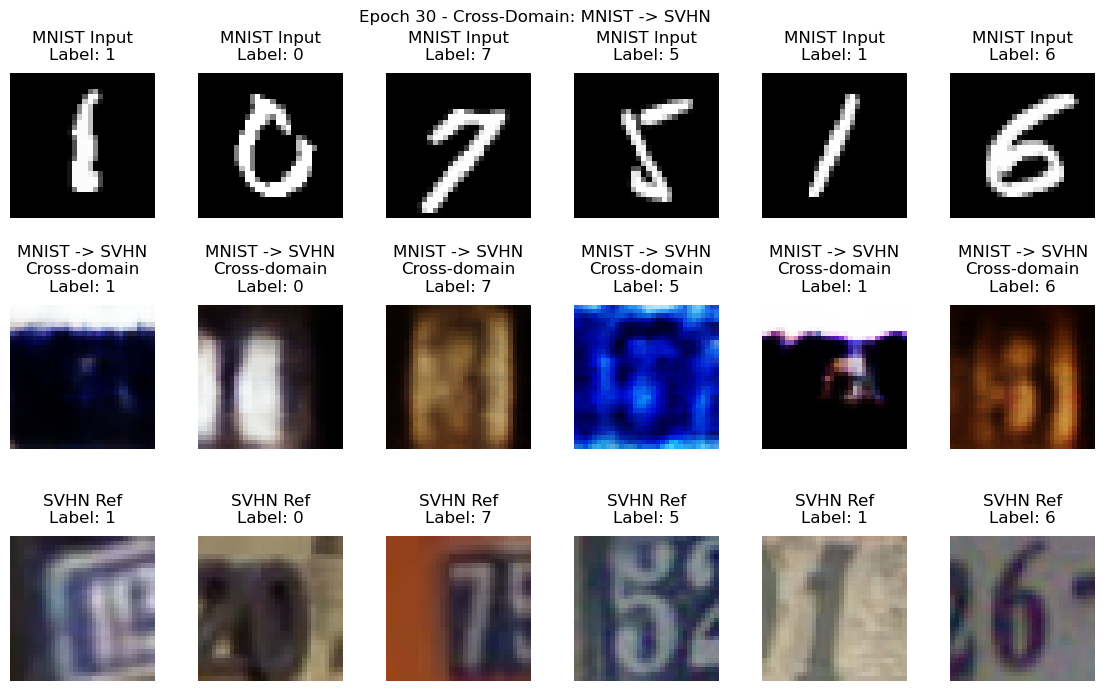

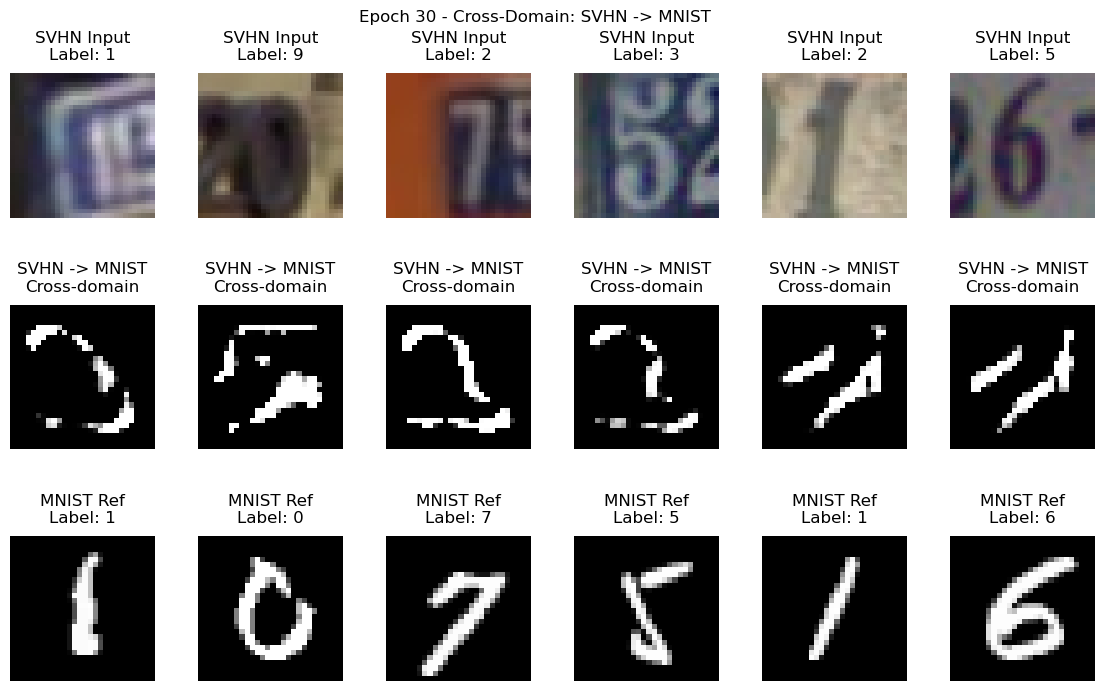

Train Epoch: 31 [0/56068 (0%)]	Loss: 2004.818359 ReconM: 75.4498 ReconS: 1895.3687 KLD: 33.9999
Train Epoch: 31 [6400/56068 (11%)]	Loss: 1987.217651 ReconM: 80.5962 ReconS: 1872.2097 KLD: 34.4117
Train Epoch: 31 [12800/56068 (23%)]	Loss: 1999.283569 ReconM: 78.5515 ReconS: 1886.0835 KLD: 34.6486
Train Epoch: 31 [19200/56068 (34%)]	Loss: 1983.309326 ReconM: 78.7559 ReconS: 1869.6813 KLD: 34.8720
Train Epoch: 31 [25600/56068 (46%)]	Loss: 1986.333618 ReconM: 76.1076 ReconS: 1875.9963 KLD: 34.2297
Train Epoch: 31 [32000/56068 (57%)]	Loss: 2036.940552 ReconM: 73.9121 ReconS: 1929.0535 KLD: 33.9750
Train Epoch: 31 [38400/56068 (68%)]	Loss: 2048.544678 ReconM: 82.3850 ReconS: 1932.6340 KLD: 33.5257
Train Epoch: 31 [44800/56068 (80%)]	Loss: 1998.423340 ReconM: 75.8538 ReconS: 1888.5677 KLD: 34.0018
Train Epoch: 31 [51200/56068 (91%)]	Loss: 2019.573364 ReconM: 77.1036 ReconS: 1907.8243 KLD: 34.6454
====> Epoch: 31 Average loss: 2007.6714
Train Epoch: 32 [0/56068 (0%)]	Loss: 2002.418945 ReconM: 

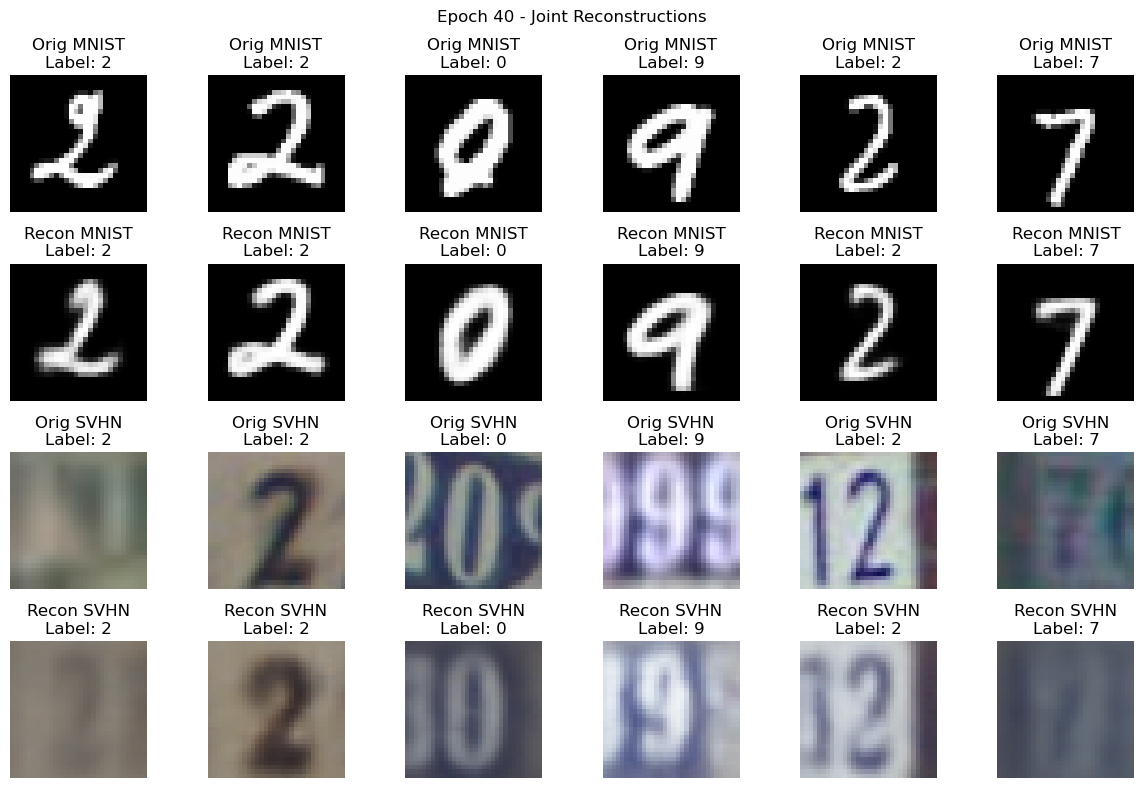

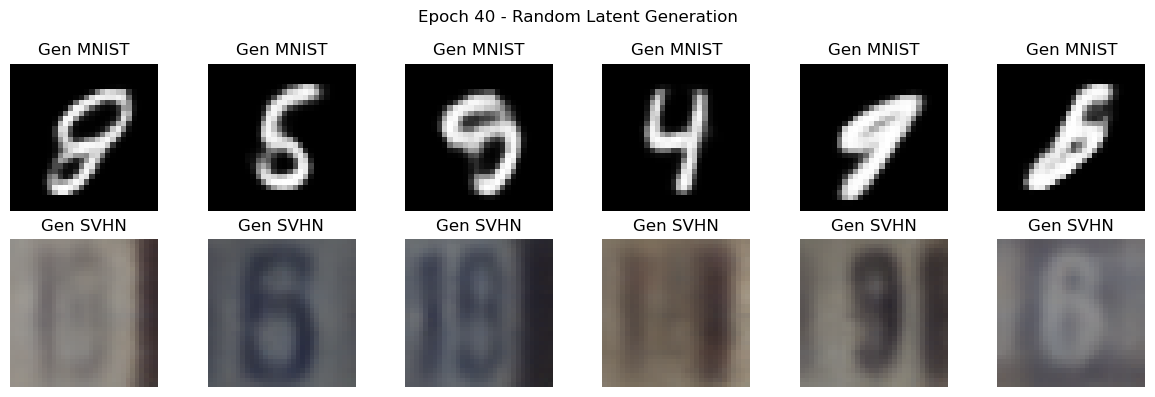

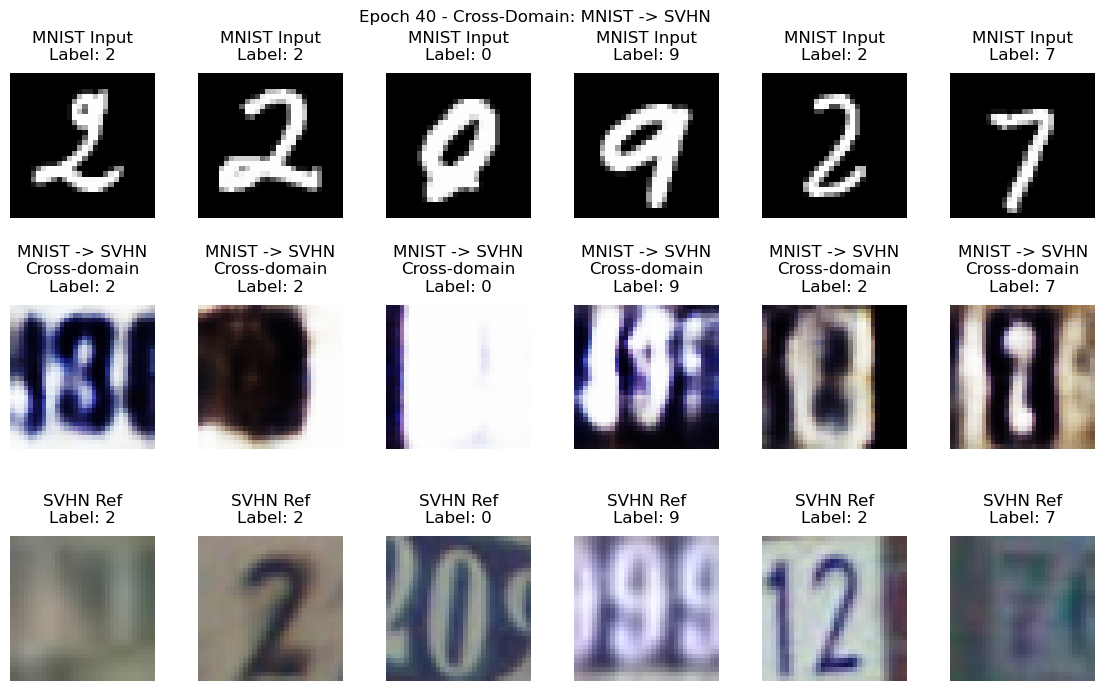

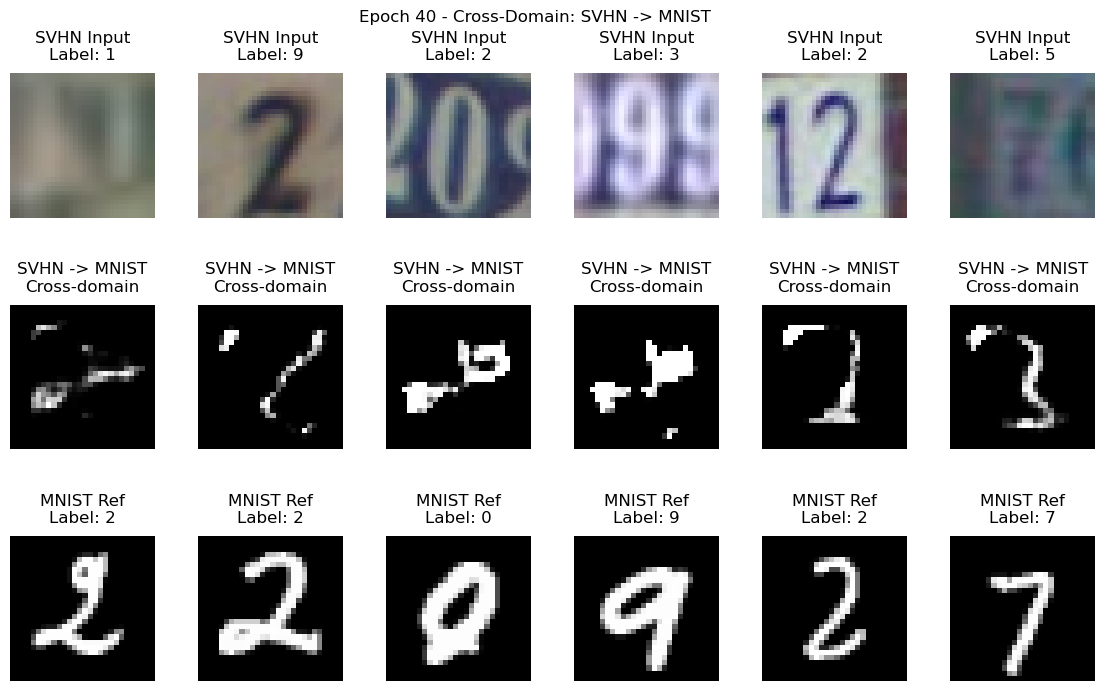

Train Epoch: 41 [0/56068 (0%)]	Loss: 2014.924072 ReconM: 76.7971 ReconS: 1902.8523 KLD: 35.2746
Train Epoch: 41 [6400/56068 (11%)]	Loss: 2023.469116 ReconM: 71.8120 ReconS: 1917.1151 KLD: 34.5420
Train Epoch: 41 [12800/56068 (23%)]	Loss: 2001.938232 ReconM: 74.9467 ReconS: 1891.4441 KLD: 35.5475
Train Epoch: 41 [19200/56068 (34%)]	Loss: 2017.949951 ReconM: 79.0381 ReconS: 1903.4714 KLD: 35.4404
Train Epoch: 41 [25600/56068 (46%)]	Loss: 2006.906372 ReconM: 76.3775 ReconS: 1895.7305 KLD: 34.7984
Train Epoch: 41 [32000/56068 (57%)]	Loss: 1952.493286 ReconM: 72.8366 ReconS: 1844.7567 KLD: 34.9001
Train Epoch: 41 [38400/56068 (68%)]	Loss: 1998.295898 ReconM: 72.4749 ReconS: 1890.7892 KLD: 35.0319
Train Epoch: 41 [44800/56068 (80%)]	Loss: 2000.622437 ReconM: 78.2944 ReconS: 1887.0743 KLD: 35.2536
Train Epoch: 41 [51200/56068 (91%)]	Loss: 1999.575317 ReconM: 75.1017 ReconS: 1889.6252 KLD: 34.8484
====> Epoch: 41 Average loss: 2005.8431
Train Epoch: 42 [0/56068 (0%)]	Loss: 2016.687622 ReconM: 

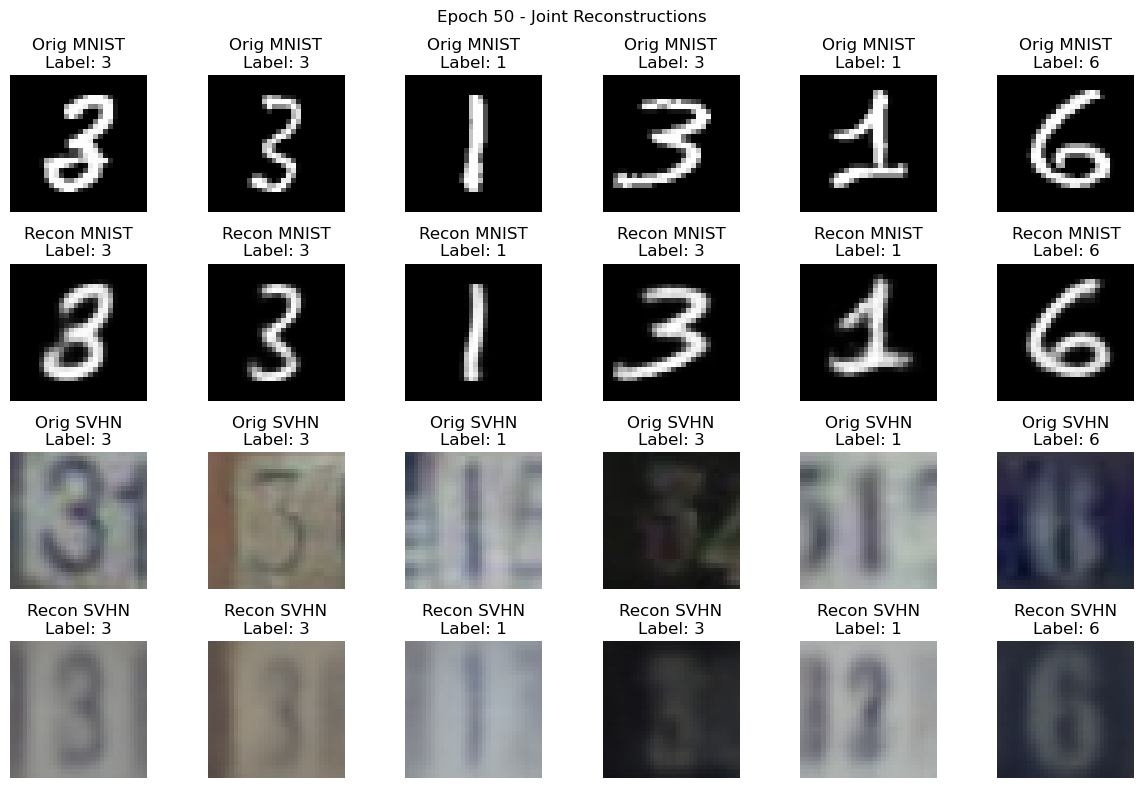

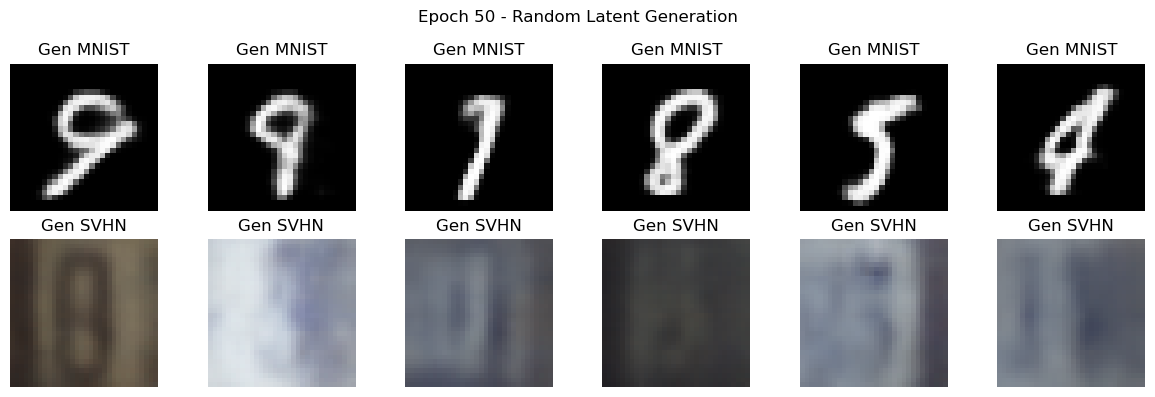

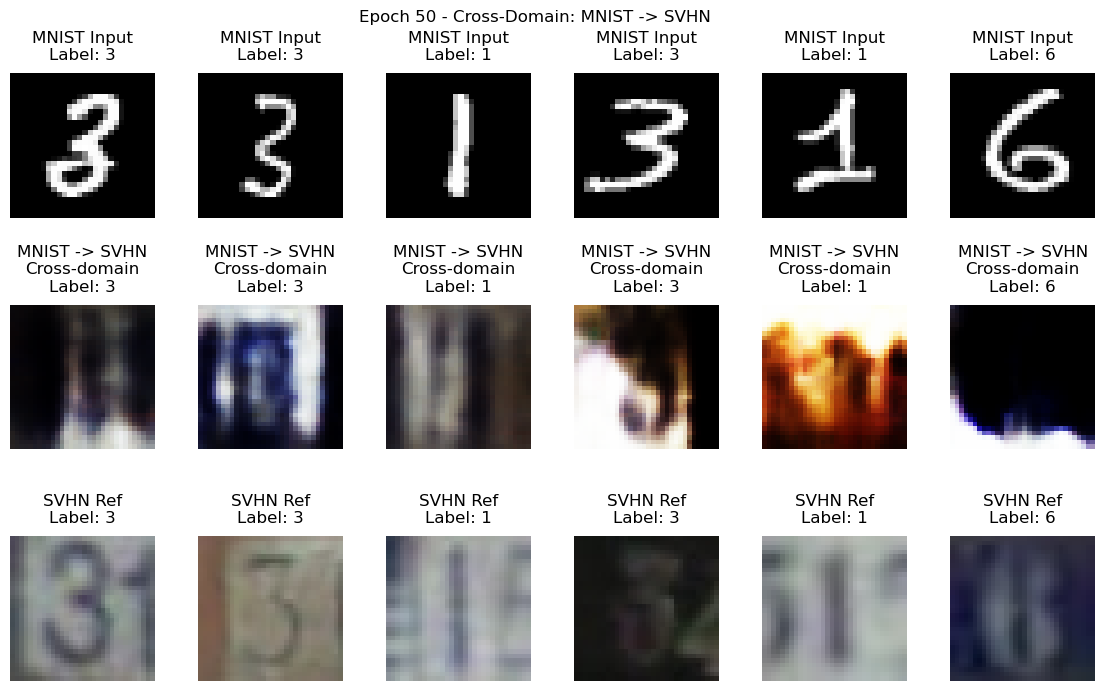

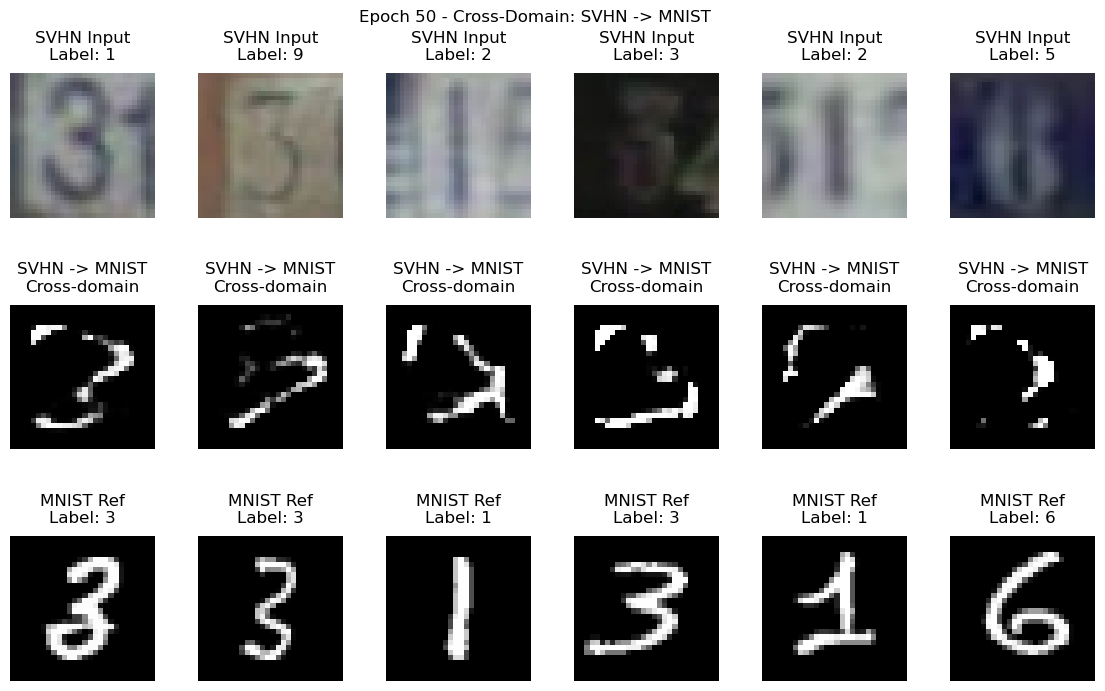

Train Epoch: 51 [0/56068 (0%)]	Loss: 2041.524292 ReconM: 77.0260 ReconS: 1929.7880 KLD: 34.7103
Train Epoch: 51 [6400/56068 (11%)]	Loss: 2030.237671 ReconM: 73.9314 ReconS: 1921.4474 KLD: 34.8589
Train Epoch: 51 [12800/56068 (23%)]	Loss: 1995.885254 ReconM: 72.5937 ReconS: 1888.5225 KLD: 34.7690
Train Epoch: 51 [19200/56068 (34%)]	Loss: 2002.279419 ReconM: 74.3378 ReconS: 1893.4446 KLD: 34.4971
Train Epoch: 51 [25600/56068 (46%)]	Loss: 1996.945557 ReconM: 72.6425 ReconS: 1889.4788 KLD: 34.8243
Train Epoch: 51 [32000/56068 (57%)]	Loss: 2033.087646 ReconM: 74.5847 ReconS: 1923.4957 KLD: 35.0071
Train Epoch: 51 [38400/56068 (68%)]	Loss: 1966.508423 ReconM: 71.8736 ReconS: 1859.5603 KLD: 35.0745
Train Epoch: 51 [44800/56068 (80%)]	Loss: 2016.621582 ReconM: 73.8555 ReconS: 1909.2906 KLD: 33.4755
Train Epoch: 51 [51200/56068 (91%)]	Loss: 2011.524658 ReconM: 77.1862 ReconS: 1899.9882 KLD: 34.3503
====> Epoch: 51 Average loss: 2004.4806
Train Epoch: 52 [0/56068 (0%)]	Loss: 2020.285645 ReconM: 

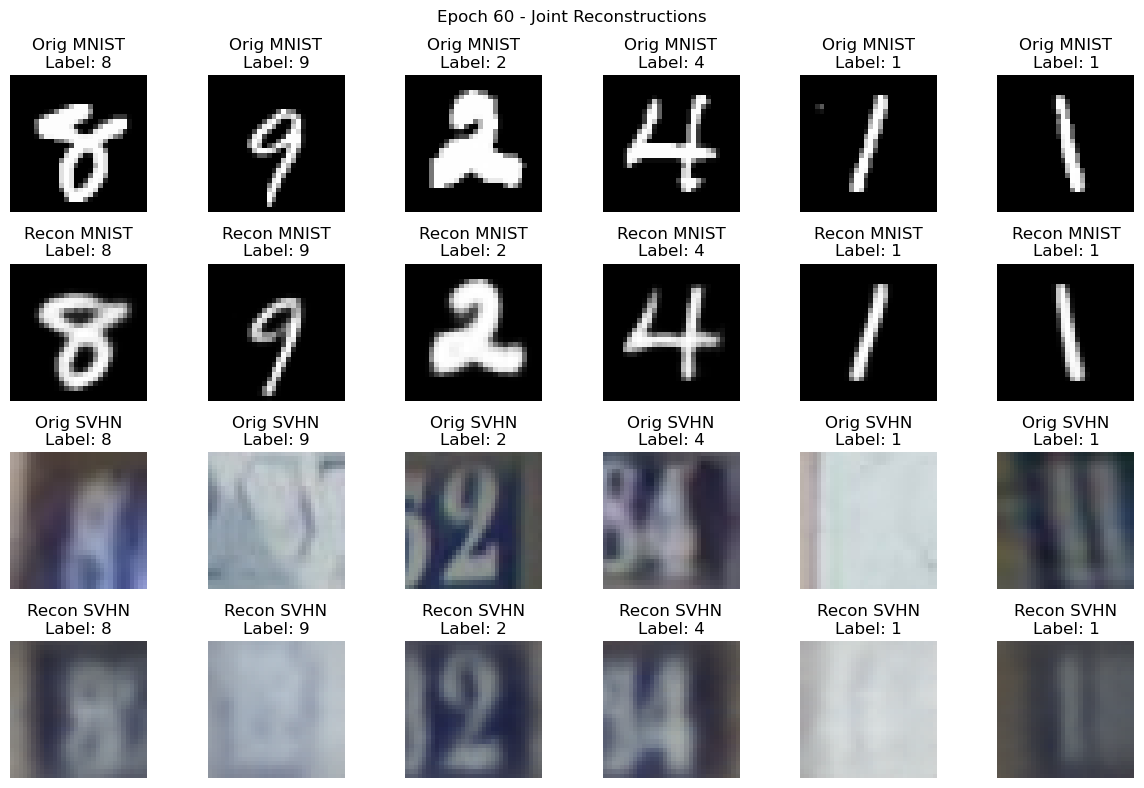

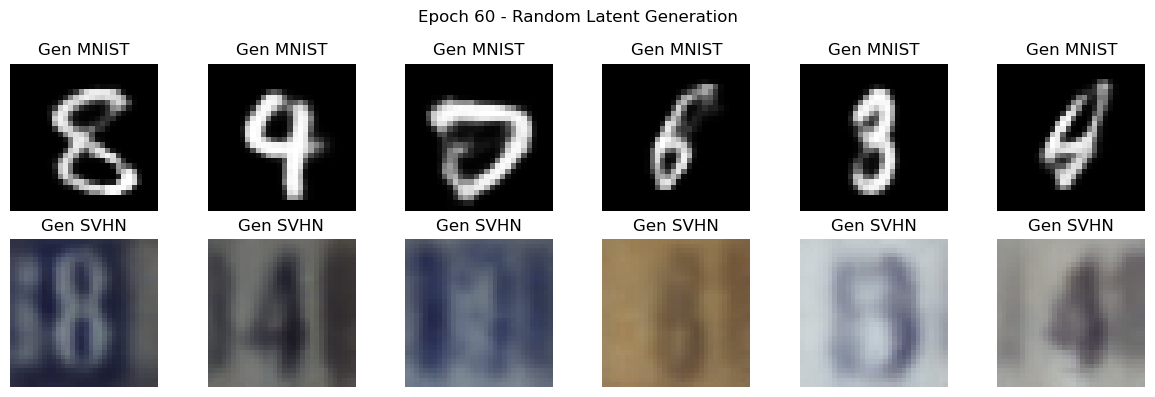

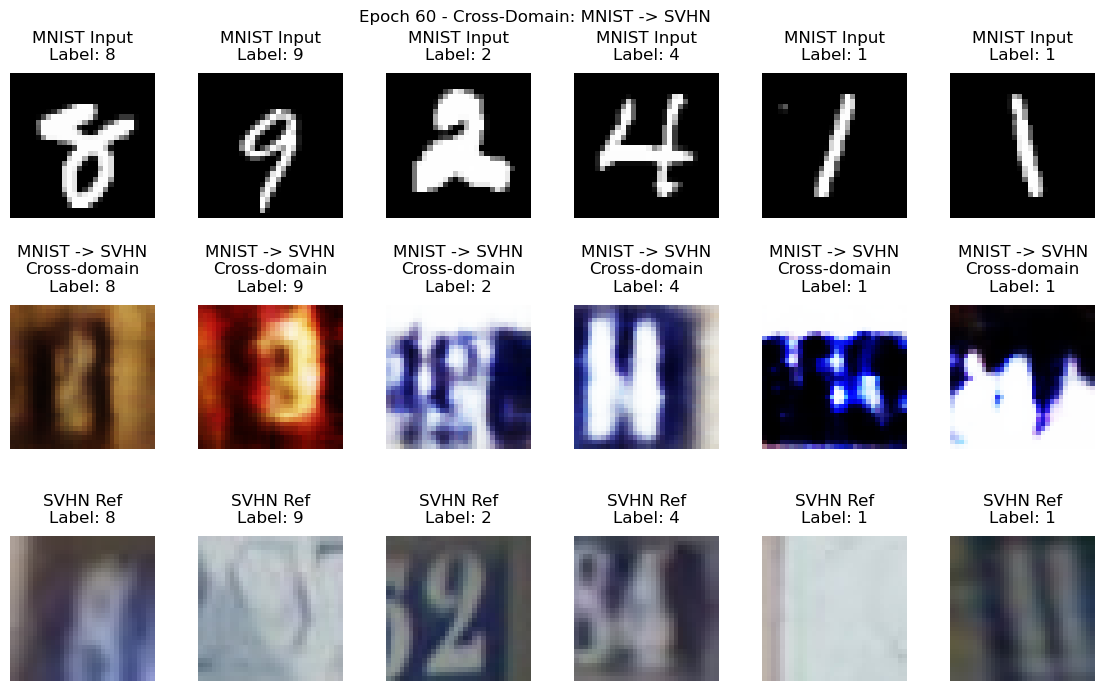

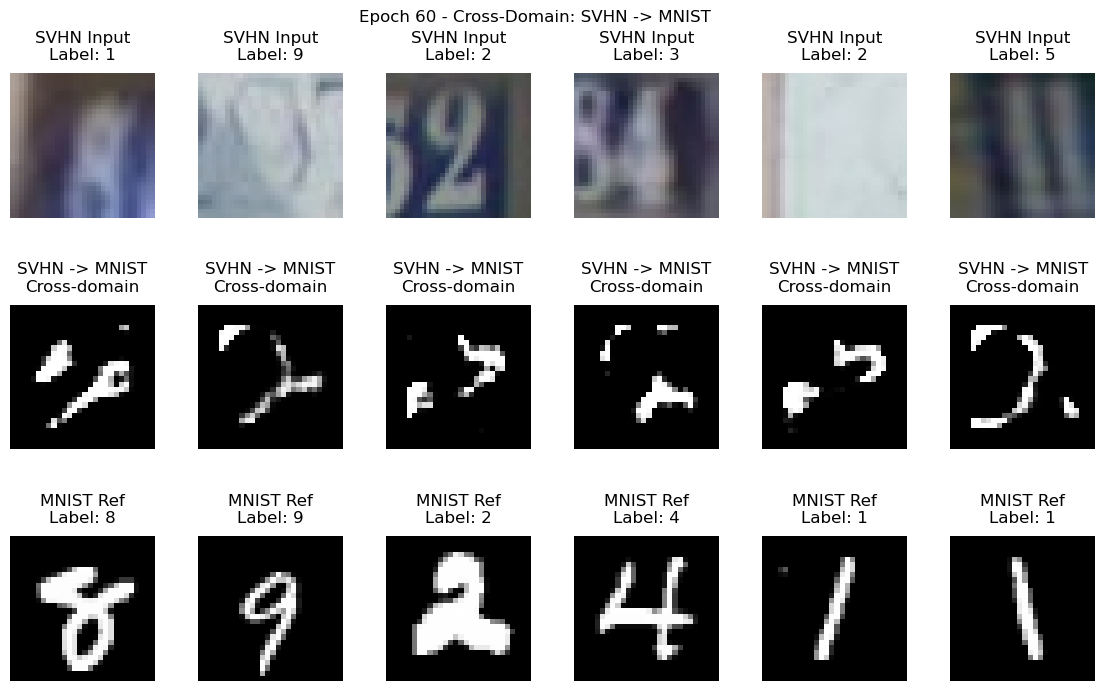

Train Epoch: 61 [0/56068 (0%)]	Loss: 1978.472412 ReconM: 78.1373 ReconS: 1864.2180 KLD: 36.1172
Train Epoch: 61 [6400/56068 (11%)]	Loss: 2027.985840 ReconM: 76.7833 ReconS: 1915.1227 KLD: 36.0798
Train Epoch: 61 [12800/56068 (23%)]	Loss: 2001.813477 ReconM: 75.8983 ReconS: 1890.2224 KLD: 35.6927
Train Epoch: 61 [19200/56068 (34%)]	Loss: 2019.014282 ReconM: 72.7640 ReconS: 1912.4285 KLD: 33.8218
Train Epoch: 61 [25600/56068 (46%)]	Loss: 1972.604004 ReconM: 79.5361 ReconS: 1856.4866 KLD: 36.5812
Train Epoch: 61 [32000/56068 (57%)]	Loss: 1987.872314 ReconM: 70.8180 ReconS: 1882.5271 KLD: 34.5272
Train Epoch: 61 [38400/56068 (68%)]	Loss: 2005.378540 ReconM: 77.1032 ReconS: 1892.3879 KLD: 35.8874
Train Epoch: 61 [44800/56068 (80%)]	Loss: 1992.101196 ReconM: 75.1122 ReconS: 1882.0259 KLD: 34.9632
Train Epoch: 61 [51200/56068 (91%)]	Loss: 2003.521606 ReconM: 79.8110 ReconS: 1887.5100 KLD: 36.2007
====> Epoch: 61 Average loss: 2003.4141
Train Epoch: 62 [0/56068 (0%)]	Loss: 1938.344360 ReconM: 

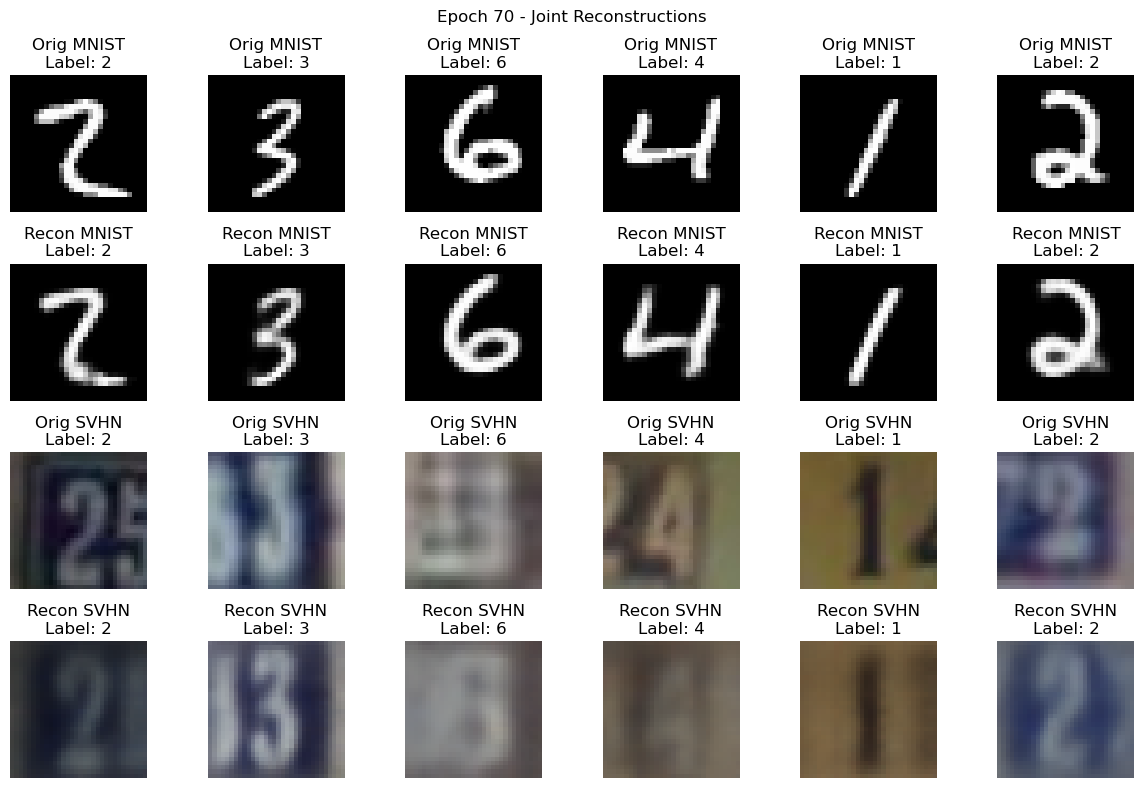

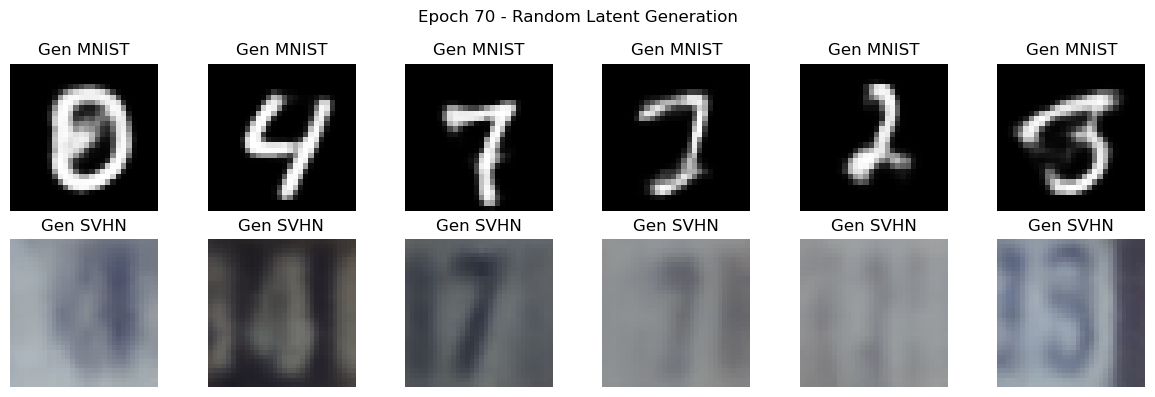

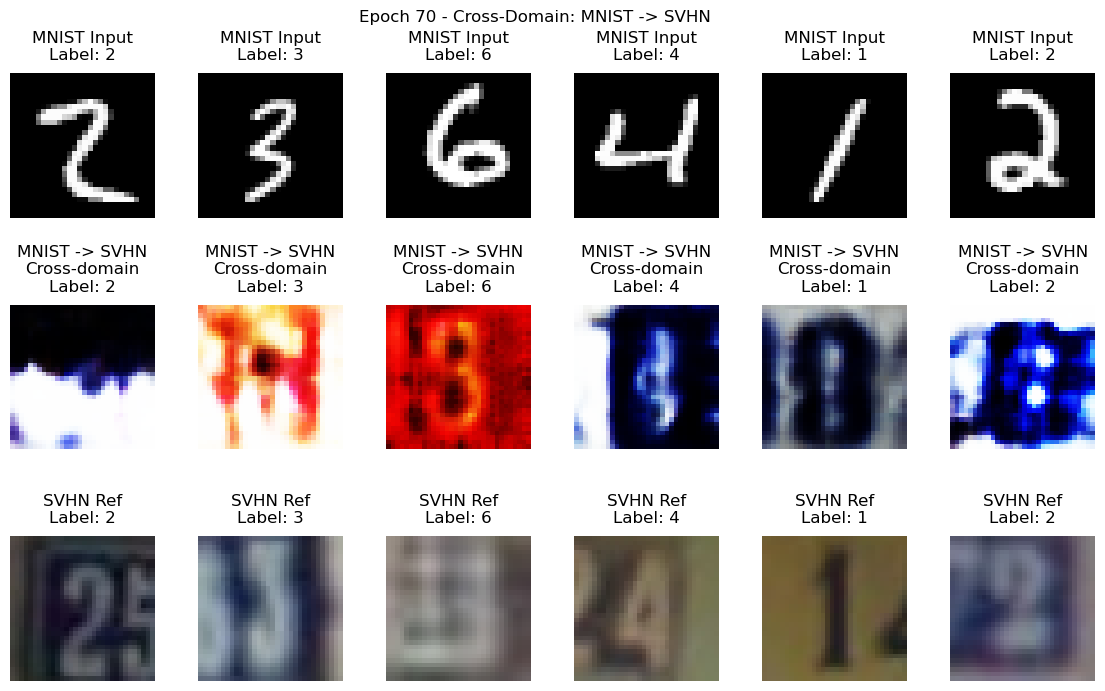

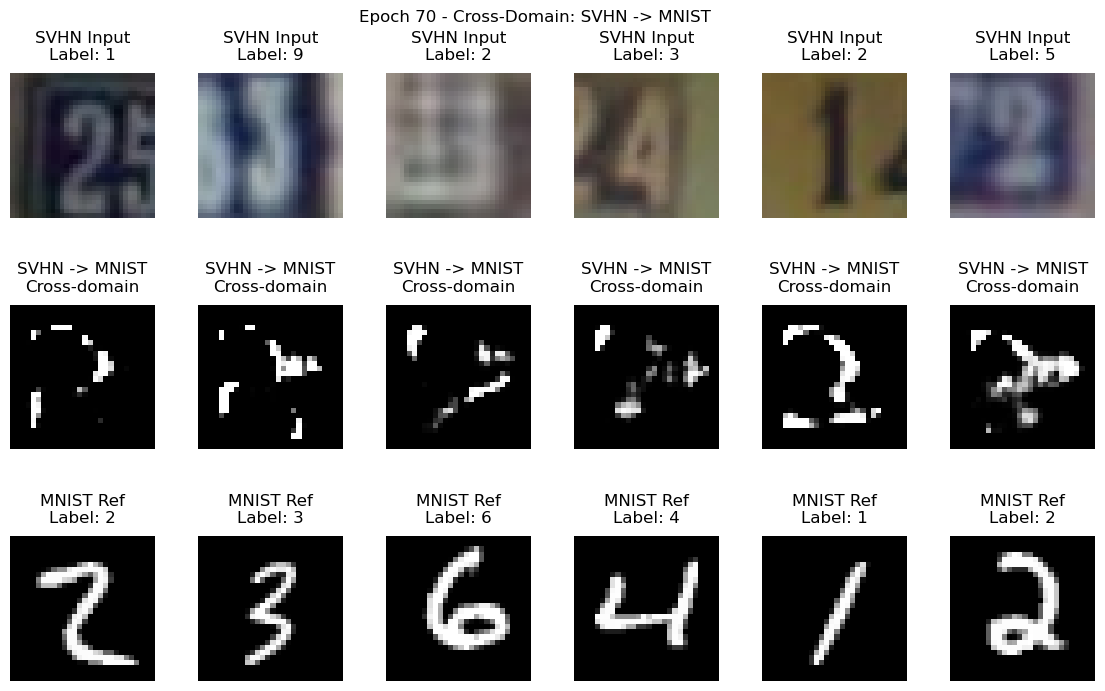

Train Epoch: 71 [0/56068 (0%)]	Loss: 1984.238647 ReconM: 74.4042 ReconS: 1874.5791 KLD: 35.2553
Train Epoch: 71 [6400/56068 (11%)]	Loss: 2025.660522 ReconM: 76.3491 ReconS: 1913.4957 KLD: 35.8157
Train Epoch: 71 [12800/56068 (23%)]	Loss: 1981.067505 ReconM: 73.7639 ReconS: 1872.0496 KLD: 35.2540
Train Epoch: 71 [19200/56068 (34%)]	Loss: 1987.338135 ReconM: 81.4713 ReconS: 1869.7815 KLD: 36.0853
Train Epoch: 71 [25600/56068 (46%)]	Loss: 2012.372192 ReconM: 79.5459 ReconS: 1897.6984 KLD: 35.1280
Train Epoch: 71 [32000/56068 (57%)]	Loss: 2019.257812 ReconM: 76.0896 ReconS: 1908.0692 KLD: 35.0989
Train Epoch: 71 [38400/56068 (68%)]	Loss: 2018.427368 ReconM: 75.8626 ReconS: 1907.4202 KLD: 35.1446
Train Epoch: 71 [44800/56068 (80%)]	Loss: 2002.873779 ReconM: 74.1711 ReconS: 1895.2119 KLD: 33.4909
Train Epoch: 71 [51200/56068 (91%)]	Loss: 2011.712280 ReconM: 70.2452 ReconS: 1907.3838 KLD: 34.0832
====> Epoch: 71 Average loss: 2002.4425
Train Epoch: 72 [0/56068 (0%)]	Loss: 2053.212891 ReconM: 

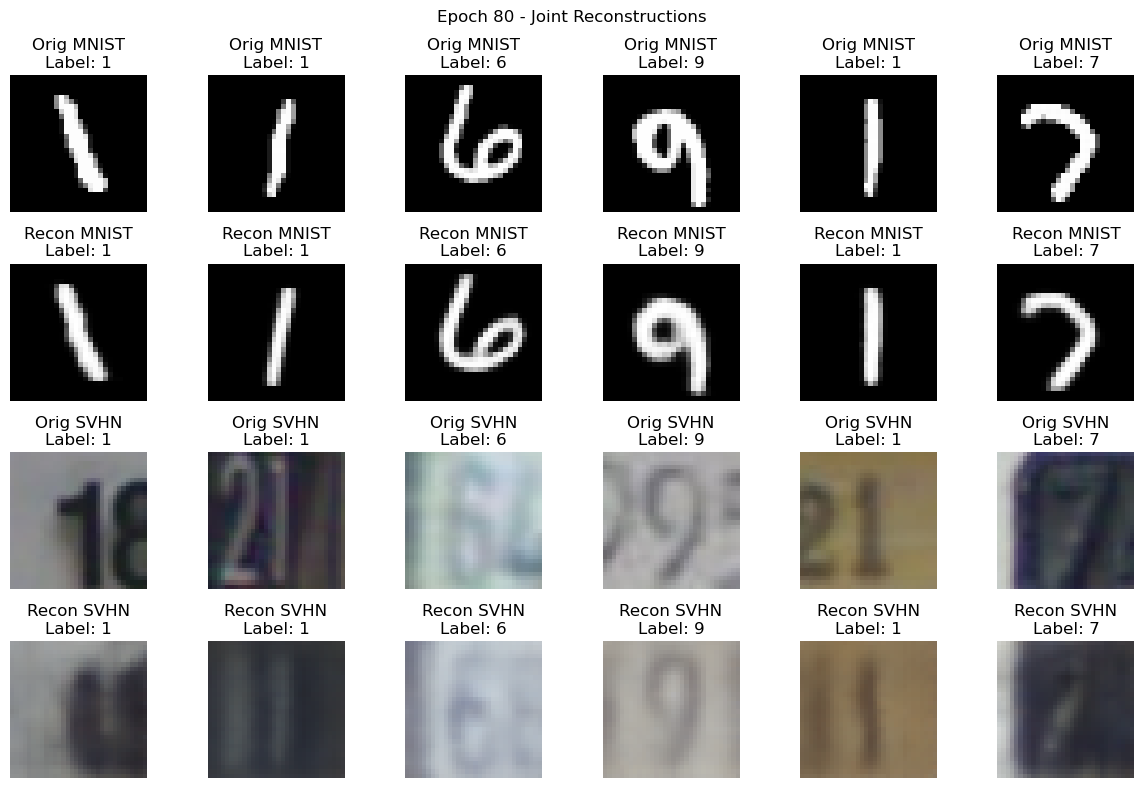

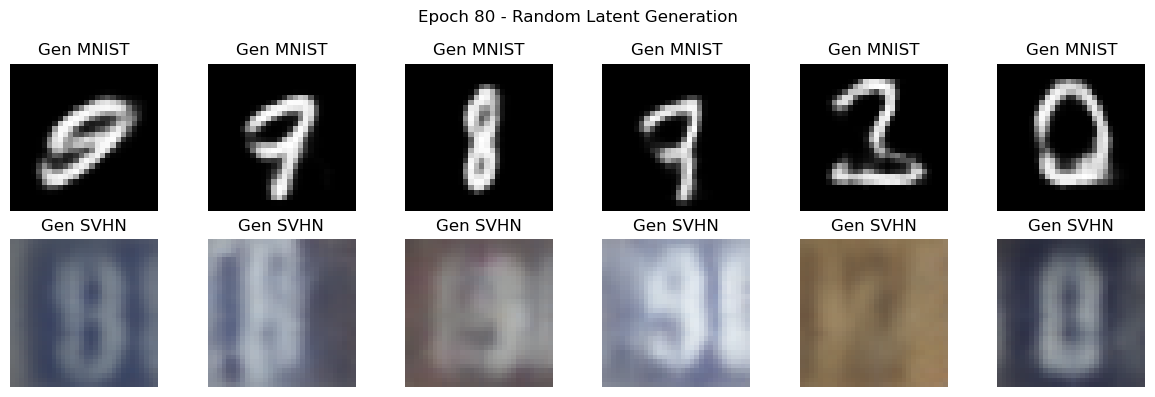

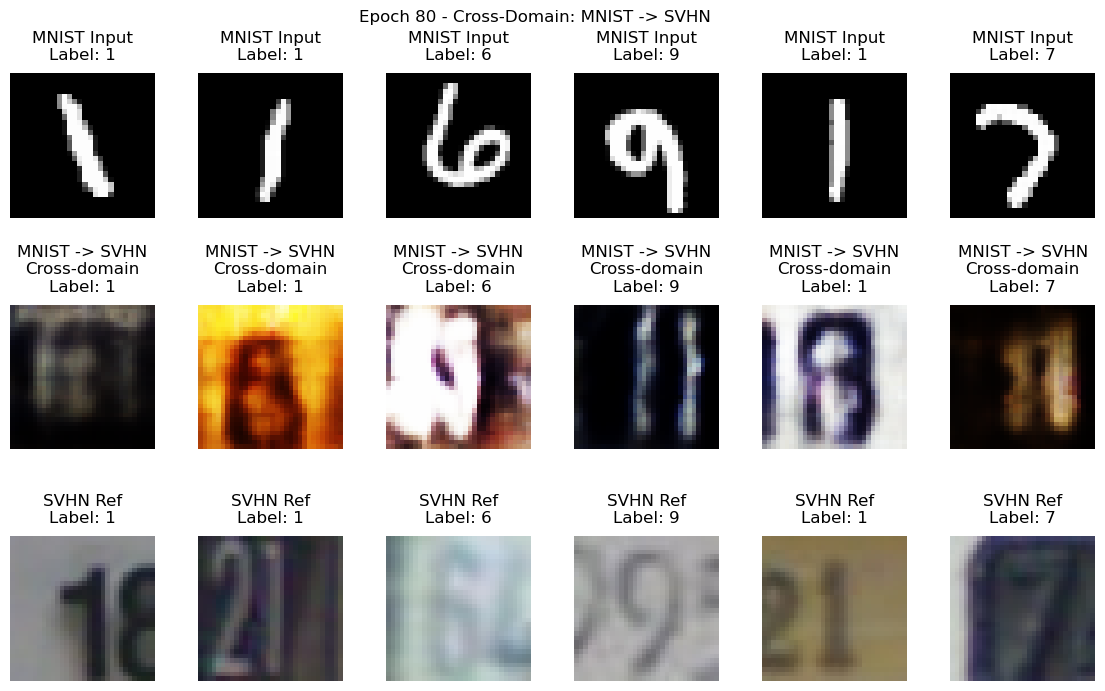

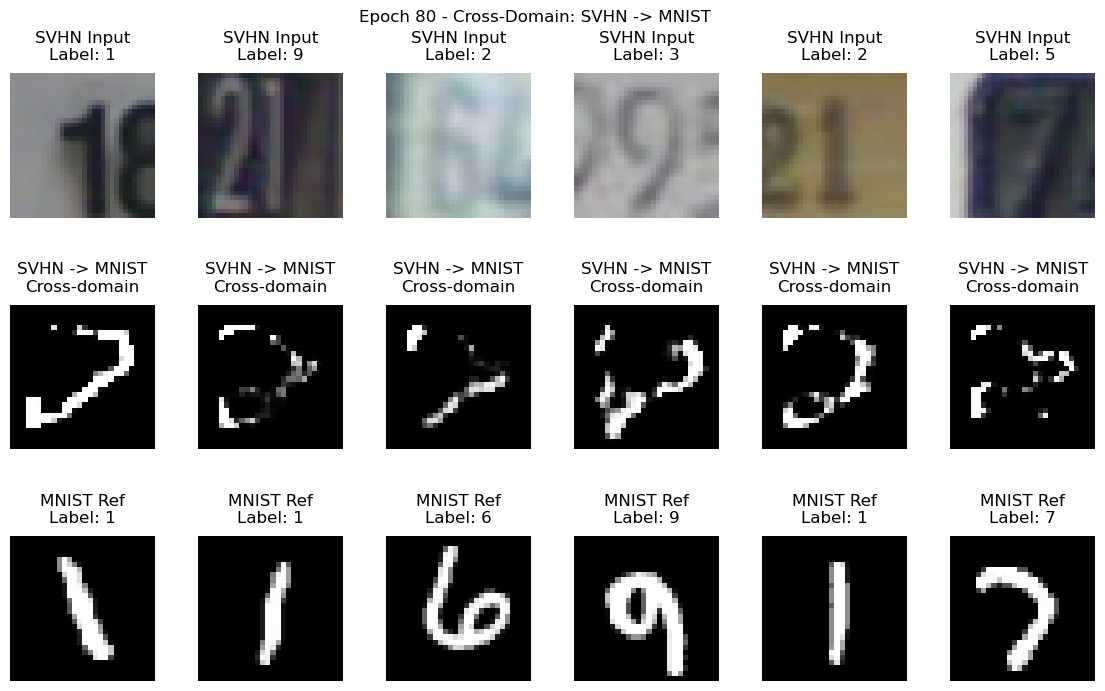

Train Epoch: 81 [0/56068 (0%)]	Loss: 1996.634644 ReconM: 77.0319 ReconS: 1885.4169 KLD: 34.1859
Train Epoch: 81 [6400/56068 (11%)]	Loss: 1995.312744 ReconM: 69.5435 ReconS: 1890.9021 KLD: 34.8672
Train Epoch: 81 [12800/56068 (23%)]	Loss: 1993.813354 ReconM: 75.1594 ReconS: 1883.4237 KLD: 35.2302
Train Epoch: 81 [19200/56068 (34%)]	Loss: 2026.365112 ReconM: 74.0039 ReconS: 1916.7083 KLD: 35.6529
Train Epoch: 81 [25600/56068 (46%)]	Loss: 2001.842896 ReconM: 68.3609 ReconS: 1899.9213 KLD: 33.5608
Train Epoch: 81 [32000/56068 (57%)]	Loss: 1967.743896 ReconM: 75.4117 ReconS: 1856.7065 KLD: 35.6256
Train Epoch: 81 [38400/56068 (68%)]	Loss: 1957.613647 ReconM: 73.8463 ReconS: 1847.5990 KLD: 36.1683
Train Epoch: 81 [44800/56068 (80%)]	Loss: 1954.605835 ReconM: 71.7845 ReconS: 1846.6066 KLD: 36.2147
Train Epoch: 81 [51200/56068 (91%)]	Loss: 1985.077881 ReconM: 77.4593 ReconS: 1871.7036 KLD: 35.9150
====> Epoch: 81 Average loss: 2001.7402
Train Epoch: 82 [0/56068 (0%)]	Loss: 2000.442505 ReconM: 

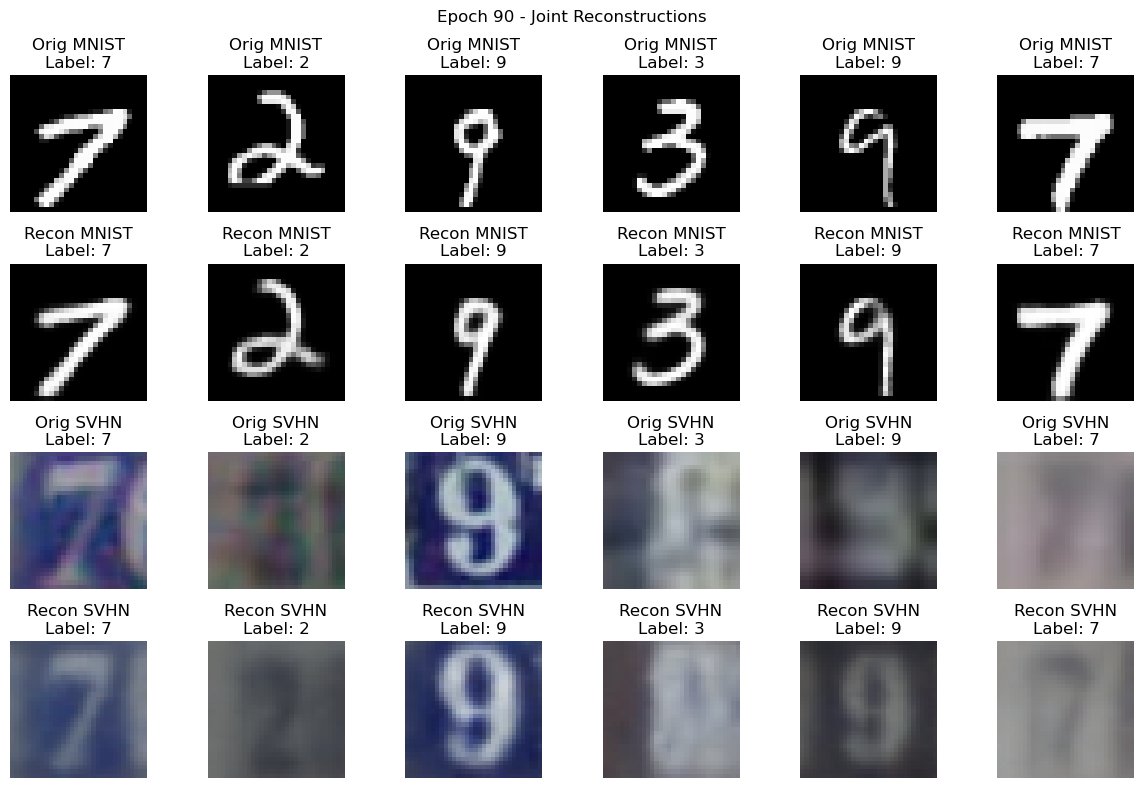

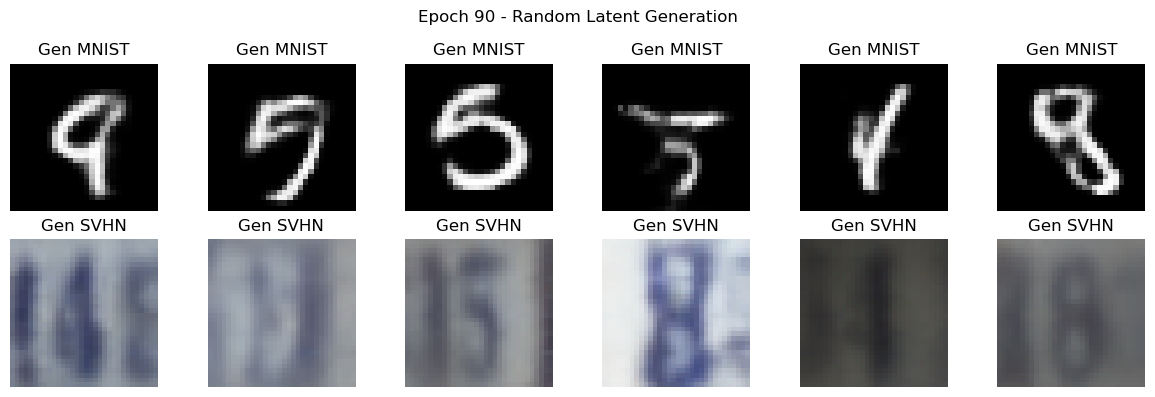

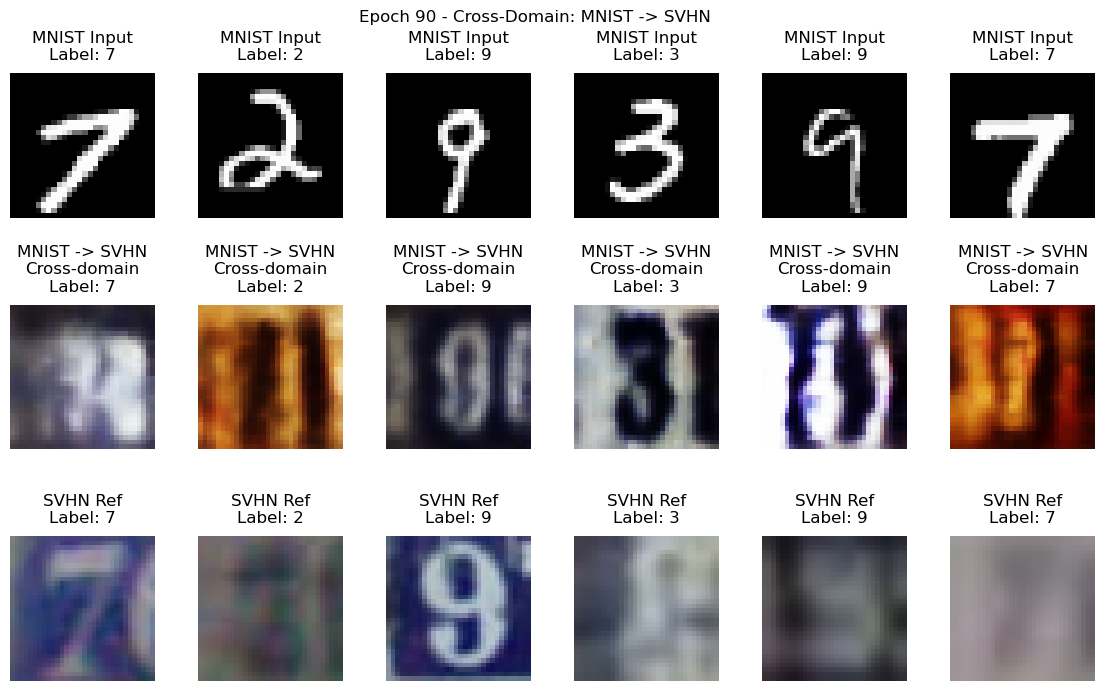

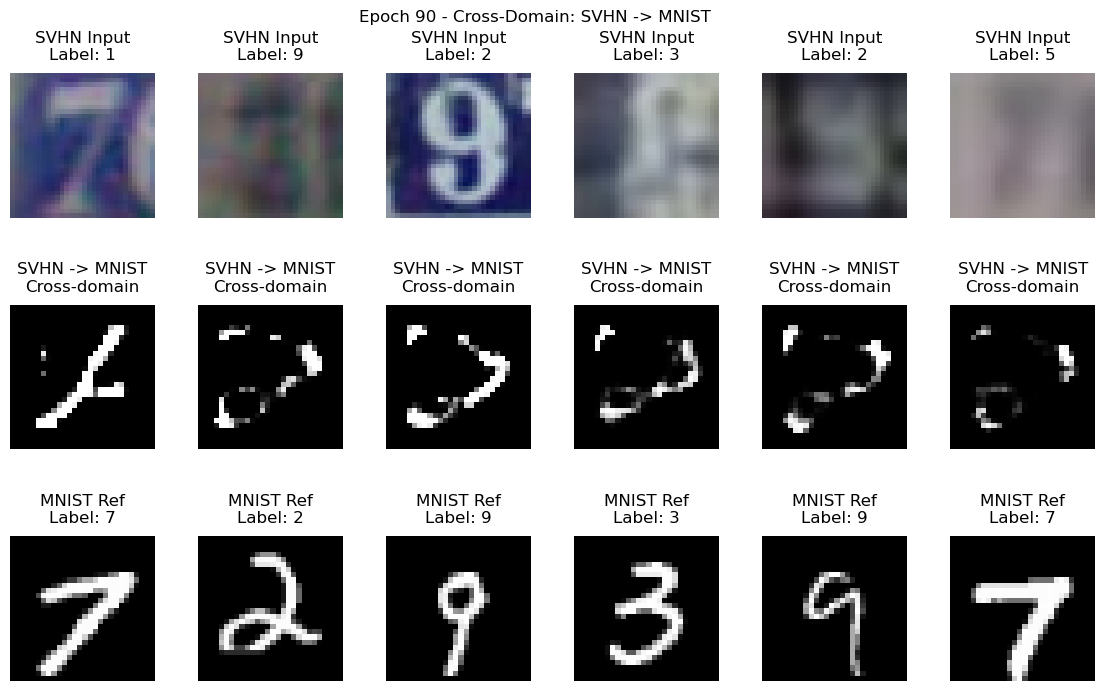

Train Epoch: 91 [0/56068 (0%)]	Loss: 2028.142090 ReconM: 78.5760 ReconS: 1913.4977 KLD: 36.0685
Train Epoch: 91 [6400/56068 (11%)]	Loss: 1980.484253 ReconM: 74.4441 ReconS: 1869.5999 KLD: 36.4403
Train Epoch: 91 [12800/56068 (23%)]	Loss: 2033.252686 ReconM: 72.6159 ReconS: 1925.7993 KLD: 34.8375
Train Epoch: 91 [19200/56068 (34%)]	Loss: 1939.679688 ReconM: 76.5761 ReconS: 1826.6187 KLD: 36.4849
Train Epoch: 91 [25600/56068 (46%)]	Loss: 2047.645264 ReconM: 77.3458 ReconS: 1934.3591 KLD: 35.9403
Train Epoch: 91 [32000/56068 (57%)]	Loss: 2028.796021 ReconM: 74.6544 ReconS: 1918.5823 KLD: 35.5593
Train Epoch: 91 [38400/56068 (68%)]	Loss: 1965.242676 ReconM: 72.9805 ReconS: 1857.3181 KLD: 34.9439
Train Epoch: 91 [44800/56068 (80%)]	Loss: 1993.480835 ReconM: 79.4457 ReconS: 1877.3016 KLD: 36.7335
Train Epoch: 91 [51200/56068 (91%)]	Loss: 2038.218750 ReconM: 75.6409 ReconS: 1927.9087 KLD: 34.6692
====> Epoch: 91 Average loss: 2000.9113
Train Epoch: 92 [0/56068 (0%)]	Loss: 2022.270020 ReconM: 

In [31]:
# Assuming 'paired_loader' yields (img_mnist, img_svhn, label1, label2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 20 # Example latent dimension
model = MultiViewVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100  # Number of epochs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (mnist_batch, svhn_batch, _, _) in enumerate(paired_loader):
        mnist_batch = mnist_batch.to(device)
        svhn_batch = svhn_batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_mnist, recon_svhn, mu_joint, logvar_joint, _, _, _, _ = model(mnist_batch, svhn_batch)

        # Calculate loss
        loss, recon_m, recon_s, kld = vae_loss(recon_mnist, mnist_batch, recon_svhn, svhn_batch, mu_joint, logvar_joint)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(mnist_batch)}/{len(paired_loader.dataset)} '
                  f'({100. * batch_idx / len(paired_loader):.0f}%)]\tLoss: {loss.item():.6f} '
                  f'ReconM: {recon_m.item():.4f} ReconS: {recon_s.item():.4f} KLD: {kld.item():.4f}')

    avg_loss = train_loss / len(paired_loader)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

    # Sample generation and visualization
    if epoch % 10 == 0:  # Every 10 epochs
        model.eval()
        with torch.no_grad():
            # Generate random samples from standard normal
            z_sample = torch.randn(6, latent_dim).to(device)
            x_gen_mnist, x_gen_svhn = model.generate(z_sample)
            
            # Get reconstructions from first batch
            mnist_batch, svhn_batch, mnist_batch_labels, svhn_batch_labels = next(iter(paired_loader))
            mnist_batch = mnist_batch.to(device)
            svhn_batch = svhn_batch.to(device)
            recon_m, recon_s, _, _, _, _, _, _ = model(mnist_batch, svhn_batch)

            # Cross-domain reconstruction (MNIST->SVHN and SVHN->MNIST)
            cross_mnist, cross_svhn = model.reconstruct_cross(x_mnist=mnist_batch)
            cross_svhn_to_mnist, cross_mnist_gen = model.reconstruct_cross(x_svhn=svhn_batch)
            
            # Visualize reconstructions with labels
            fig, axes = plt.subplots(4, 6, figsize=(12, 8))
            for i in range(6):
                # Original MNIST
                axes[0, i].imshow(mnist_batch[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title(f'Orig MNIST\nLabel: {mnist_batch_labels[i]}')
                axes[0, i].axis('off')
                
                # Reconstructed MNIST
                axes[1, i].imshow(recon_m[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title(f'Recon MNIST\nLabel: {mnist_batch_labels[i]}')
                axes[1, i].axis('off')
                
                # Original SVHN
                axes[2, i].imshow(svhn_batch[i].cpu().permute(1, 2, 0))
                axes[2, i].set_title(f'Orig SVHN\nLabel: {svhn_batch_labels[i]}')
                axes[2, i].axis('off')
                
                # Reconstructed SVHN
                axes[3, i].imshow(recon_s[i].cpu().permute(1, 2, 0))
                axes[3, i].set_title(f'Recon SVHN\nLabel: {svhn_batch_labels[i]}')
                axes[3, i].axis('off')

            plt.suptitle(f'Epoch {epoch} - Joint Reconstructions')
            plt.tight_layout()
            plt.show()
            
            # Generated samples
            fig, axes = plt.subplots(2, 6, figsize=(12, 4))
            for i in range(6):
                axes[0, i].imshow(x_gen_mnist[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title('Gen MNIST')
                axes[0, i].axis('off')
                
                axes[1, i].imshow(x_gen_svhn[i].cpu().permute(1, 2, 0))
                axes[1, i].set_title('Gen SVHN')
                axes[1, i].axis('off')
            
            plt.suptitle(f'Epoch {epoch} - Random Latent Generation')
            plt.tight_layout()
            plt.show()

            # Cross-domain generation (MNIST encoder -> SVHN decoder)
            fig, axes = plt.subplots(3, 6, figsize=(14, 8))
            for i in range(6):
                # Original MNIST
                axes[0, i].imshow(mnist_batch[i].cpu().squeeze(), cmap='gray')
                axes[0, i].set_title(f'MNIST Input\nLabel: {mnist_batch_labels[i]}', pad=10)
                axes[0, i].axis('off')
                
                # MNIST->SVHN cross reconstruction
                axes[1, i].imshow(cross_svhn[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[1, i].set_title(f'MNIST -> SVHN\nCross-domain\nLabel: {mnist_batch_labels[i]}', pad=10)
                axes[1, i].axis('off')
                
                # Original SVHN for reference
                axes[2, i].imshow(svhn_batch[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[2, i].set_title(f'SVHN Ref\nLabel: {svhn_batch_labels[i]}', pad=10)
                axes[2, i].axis('off')

            plt.suptitle(f'Epoch {epoch} - Cross-Domain: MNIST -> SVHN', y=0.98)
            plt.subplots_adjust(top=0.93, hspace=0.2, wspace=0.3)
            plt.show()

            # Cross-domain generation (SVHN encoder -> MNIST decoder)
            fig, axes = plt.subplots(3, 6, figsize=(14, 8))
            for i in range(6):
                # Original SVHN
                axes[0, i].imshow(svhn_batch[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[0, i].set_title(f'SVHN Input\nLabel: {svhn_labels[i]}', pad=10)
                axes[0, i].axis('off')
                
                # SVHN->MNIST cross reconstruction
                axes[1, i].imshow(cross_svhn_to_mnist[i].cpu().squeeze(), cmap='gray')
                axes[1, i].set_title('SVHN -> MNIST\nCross-domain', pad=10)
                axes[1, i].axis('off')
                
                # Original MNIST for reference
                axes[2, i].imshow(mnist_batch[i].cpu().squeeze(), cmap='gray')
                axes[2, i].set_title(f'MNIST Ref\nLabel: {mnist_batch_labels[i]}', pad=10)
                axes[2, i].axis('off')
        
            plt.suptitle(f'Epoch {epoch} - Cross-Domain: SVHN -> MNIST', y=0.98)
            plt.subplots_adjust(top=0.93, hspace=0.2, wspace=0.3)
            plt.show()

        model.train()

We have generated reconstructions, random latent generations, and cross-domain generations after each epoch to visualize the model's performance. The results show how well the model can reconstruct inputs from both views and generate new samples by sampling from the latent space.

Finally, we will visualize our latent space using t-SNE to see how well the model has learned to cluster the different digit classes in the shared latent space. This will help us understand how effectively the multi-view VAE has captured the underlying structure of the data across both views.

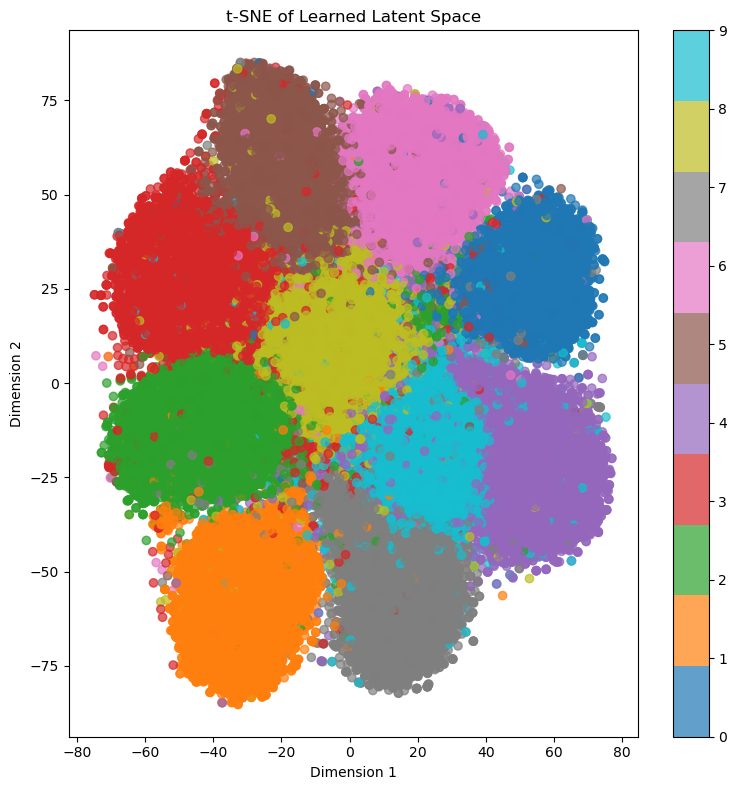

In [32]:
# Visualize learned latent space with t-SNE
from sklearn.manifold import TSNE
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

def visualize_latent_space(model, data_loader, device):
    # Extract latent representations
    model.eval()
    latents = []
    labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for mnist_batch, svhn_batch, mnist_labels, svhn_labels in data_loader:
            mnist_batch = mnist_batch.to(device)
            svhn_batch = svhn_batch.to(device)

            mu_joint, logvar_joint = model.encoder_mnist(mnist_batch)
            mu_svhn, logvar_svhn = model.encoder_svhn(svhn_batch)
            mu_combined, logvar_combined = product_of_experts(mu_joint, logvar_joint, mu_svhn, logvar_svhn)

            latents.append(mu_combined.cpu().numpy())
            labels.append(mnist_labels.numpy()) 

    # Concatenate all batches
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('t-SNE of Learned Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

visualize_latent_space(model, paired_loader, device)